In [29]:
#Getting dataframe setup
import pandas as pd

#Causal inference library
from dowhy import CausalModel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Getting libraries for Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

#testing effect modification 
import statsmodels.api as sm
import statsmodels.formula.api as smf

#for modelling 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Load dataframe
df = pd.read_csv('./out/df.csv')

In [5]:
#Add kill participation 
df['adc_killpart'] = ((df['adc_kills'] + df['adc_assists']) / df['kills']) 
df['jng_killpart'] = ((df['jng_kills'] + df['jng_assists']) / df['kills']) 

#add pre 10 kill participation for jng
#df['jng_killpartat10'] = ((df['jng_killsat10']+df['jng_assistsat10']) / df['killsat10'])

In [ ]:
df = df.dropna()
print(df['jng_gol'])

gameid                object
teamid                object
result                 int64
side                  object
kills                  int64
                      ...   
opp_rating_before    float64
rating_after         float64
rating_gain          float64
adc_killpart         float64
jng_killpart         float64
Length: 66, dtype: object


In [37]:
#Define performance features for both roles 
#mb add adc_totaldamage
#for now add only killpart and maybe show trough other stuff that kills also should be add idk
adc_performance_features = ['adc_killpart', 'adc_dpm', 'adc_cspm', 'adc_damagetakenperminute','adc_deaths']
jng_performance_features = ['jng_killpart', 'jng_cspm', 'jng_dpm'] 

In [8]:
#Define the causal graph
#TODO: Draw the proper graph up again please so I can be sure of results
causal_graph = '''
digraph {
    opp_rating_before -> win_prob;
    opp_rating_before -> post_match_rating;
    rating_before -> win_prob;
    rating_before -> rating_after;
    side_adv -> win_prob;
    win_prob -> result;
    win_prob -> golddiffat15;
    win_prob -> gamelength;
    visionscore -> gamelength;
    visionscore -> kills;
    kills -> golddiffat15;
    kills -> jng_killpart;
    kills -> adc_killpart;
    golddiffat15 -> result;
    adc_dpm -> adc_kills;
    adc_dpm -> adc_assists;
    adc_dpm -> result;
    jng_dpm -> jng_kills;
    jng_dpm -> jng_assists;
    adc_kills -> kills;
    adc_kills -> adc_killpart;
    adc_assists -> adc_killpart;
    jng_kills -> kills; 
    jng_kills -> jng_killpart;
    jng_assists -> jng_killpart;
    adc_killpart -> result;
    jng_killpart -> result;
    result -> rating_after;
    adc_cspm -> golddiffat15;
    adc_cspm -> result;
    jng_cspm -> golddiffat15;
    jng_cspm -> result;
    adc_deaths -> result;
    jng_deaths -> result;
    adc_damagetakenperminute -> adc_deaths;
}
'''

In [9]:
def causal_inference(treatment, outcome, method_name = 'backdoor.linear_regression', data = df):
    #Create causal model
    model = CausalModel(
        data = data,
        treatment = treatment,
        outcome = outcome,
        graph = causal_graph
    )

    #Identify causal effects
    identified_estimand = model.identify_effect()

    #Estimate the causal effect using backdoor adjustment with linearregression
    estimate = model.estimate_effect(
        identified_estimand,
        method_name = method_name
    )
    
    refute_results = None
    #refute_results = model.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')

    return estimate, refute_results

In [43]:
#TODO Note the not fully complete graph since im not sure about killpart etc so its not in the graph right now 
for feature in adc_performance_features:
    estimate, _ = causal_inference(feature, 'result')
    print(f'Estimate for the causal effect of {feature} on the result: {estimate.value}')
    
for feature in jng_performance_features:
    estimate, _ = causal_inference(feature, 'result')
    print(f'Estimate for the causal effect of {feature} on the result: {estimate.value}')


Estimate for the causal effect of adc_killpart on the result: 0.19716414285707878


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of adc_dpm on the result: 0.00025927806631848016


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of adc_cspm on the result: 0.006768097456461619


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of adc_damagetakenperminute on the result: -0.0007198617017299958


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of jng_killpart on the result: 0.040134635095889604


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of jng_cspm on the result: 0.016706927469947175


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of jng_dpm on the result: 0.0003182545692027583


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of jng_deaths on the result: -0.10252868545142524


g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


Estimate for the causal effect of jng_kills on the result: 0.036915443573575235


Estimate for the causal effect of adc_killpart on the result: 0.19716414285707878
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of adc_dpm on the result: 0.00025927806631848016
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of adc_cspm on the result: 0.006768097456461619
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of adc_damagetakenperminute on the result: -0.0007198617017299958
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of jng_killpart on the result: 0.040134635095889604
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of jng_cspm on the result: 0.016706927469947175
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of jng_dpm on the result: 0.0003182545692027583
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of jng_deaths on the result: -0.10252868545142524
g:\Users\Johannes\anaconda3\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
Estimate for the causal effect of jng_kills on the result: 0.036915443573575235

In [38]:
#We want to add a model for each set of performance variables which tries to predict outcomes for both games
#Model using the adc performance features
X_adc = df[adc_performance_features]
y_adc = df['result']

#Create the train and test split with size of test set being 0.3
X_adc_train, X_adc_test, y_adc_train, y_adc_test = train_test_split(X_adc, y_adc, random_state=42, test_size=0.3)

#Scale data
scaler = StandardScaler()
X_adc_train_scaled = scaler.fit_transform(X_adc_train)
X_adc_test_scaled = scaler.fit_transform(X_adc_test)

log_reg_adc = LogisticRegression()
#Train model on the training data
log_reg_adc.fit(X_adc_train_scaled, y_adc_train)

#Predict using the testing data
y_adc_pred = log_reg_adc.predict(X_adc_test_scaled)
y_adc_prob = log_reg_adc.predict_proba(X_adc_test_scaled)[:,1]

#Print results
print(f'Accuracy:{accuracy_score(y_adc_test, y_adc_pred)}')
print("AUC:", roc_auc_score(y_adc_test, y_adc_prob))
print("Classification Report:\n", classification_report(y_adc_test, y_adc_pred))

Accuracy:0.7727729885057472
AUC: 0.843957429425803
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77     20772
           1       0.77      0.78      0.78     20988

    accuracy                           0.77     41760
   macro avg       0.77      0.77      0.77     41760
weighted avg       0.77      0.77      0.77     41760



In [39]:
#Create a results dataframe 
full_test = df.loc[X_adc_test.index].copy()

# Add the model predictions
full_test['predicted_result_adc'] = y_adc_pred
full_test['predicted_prob_adc'] = y_adc_prob

#create tp, fp, tn, fn
tp = full_test[
    (full_test['result'] == 1) &
    (full_test['predicted_result_adc'] == 1)
]

fp = full_test[
    (full_test['result'] == 0) &
    (full_test['predicted_result_adc'] == 1)
]

tn = full_test[
    (full_test['result'] == 0) &
    (full_test['predicted_result_adc'] == 0)
]

fn = full_test[
    (full_test['result'] == 1) &
    (full_test['predicted_result_adc'] == 0)
]

#filter for features to look at 
numeric_features = full_test.select_dtypes(include=['number']).columns
other_features = [f for f in numeric_features if f not in adc_performance_features + ['result']]

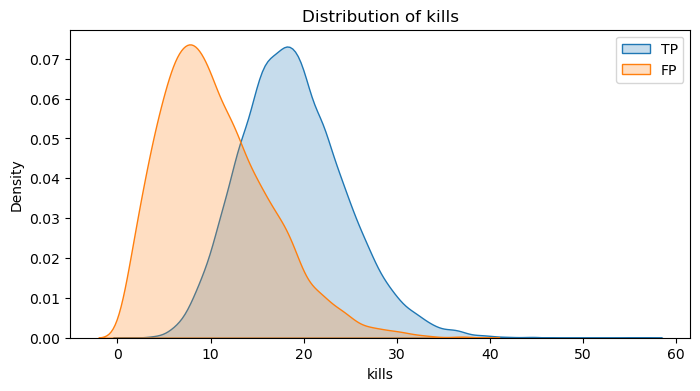

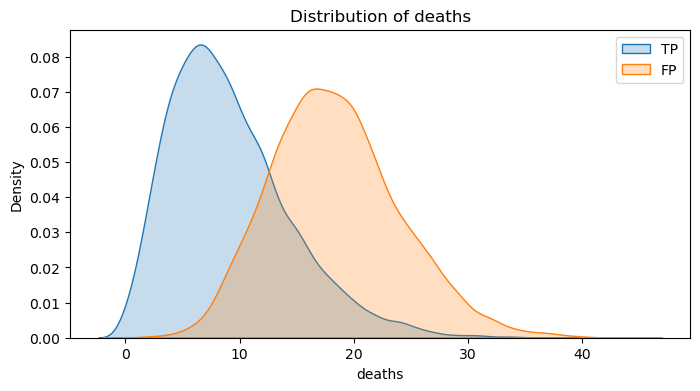

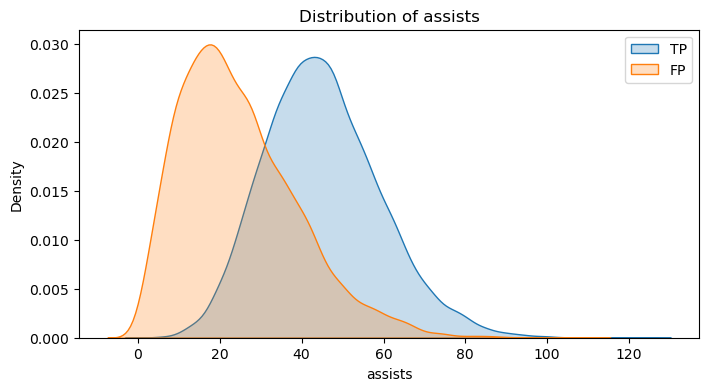

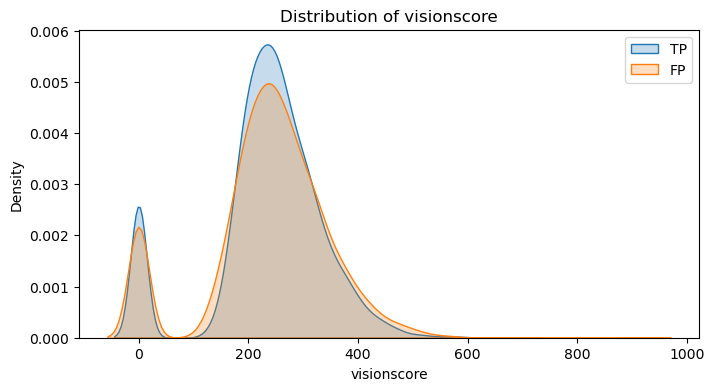

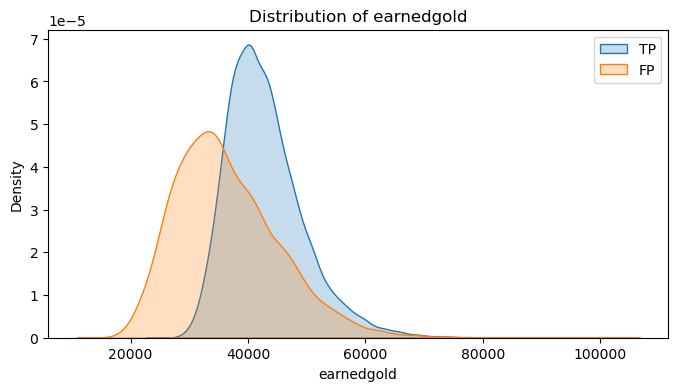

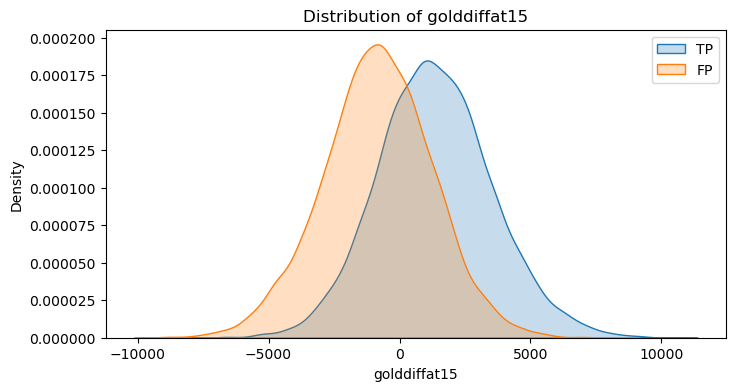

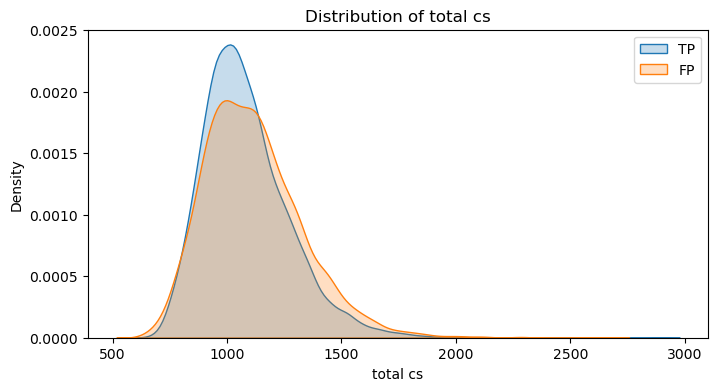

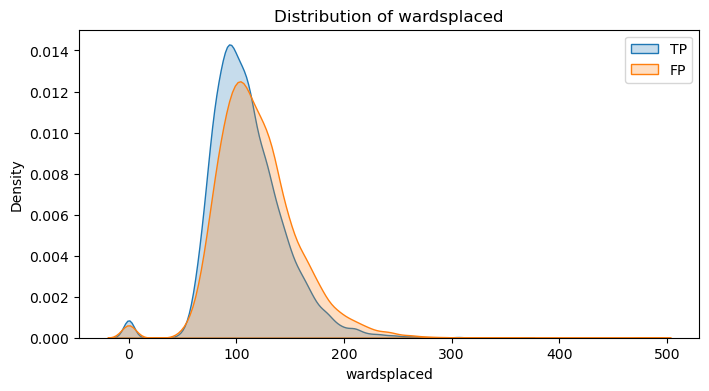

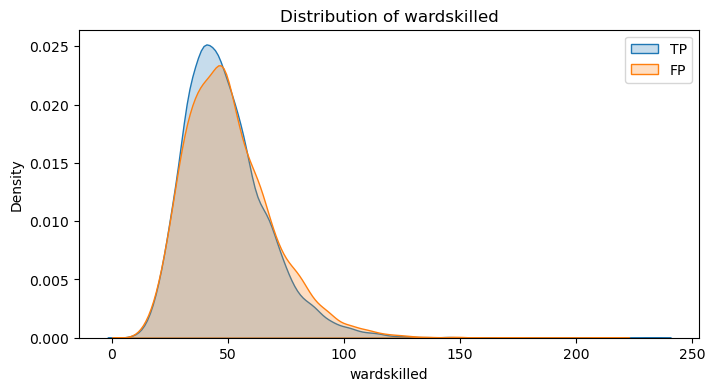

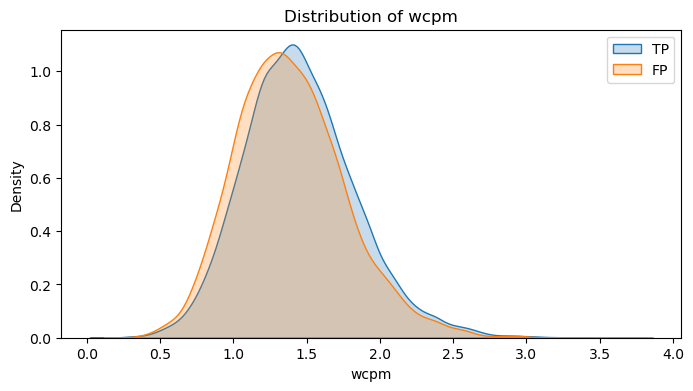

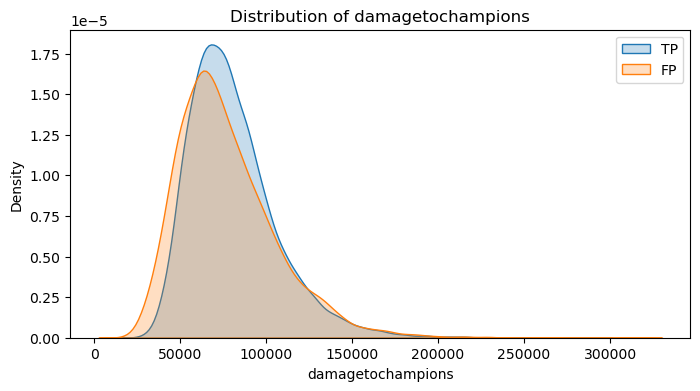

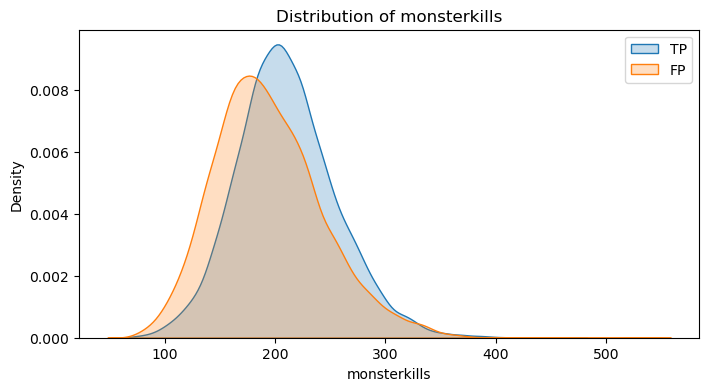

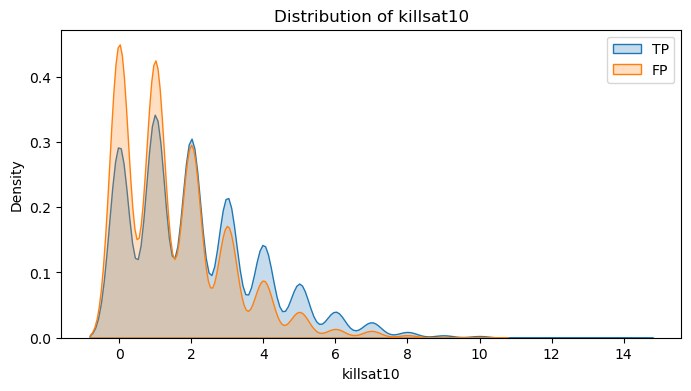

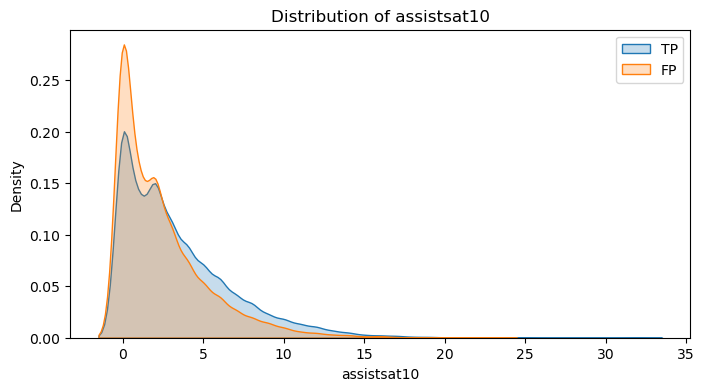

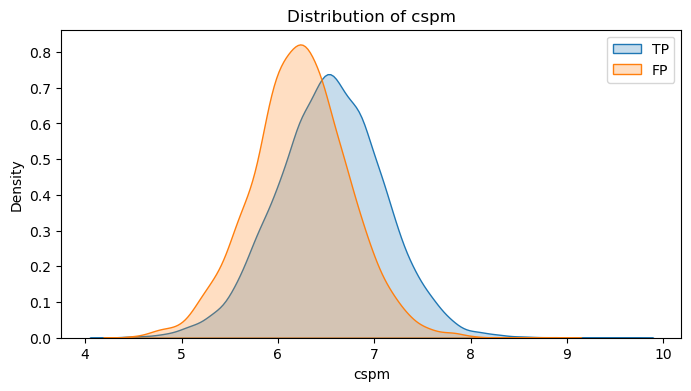

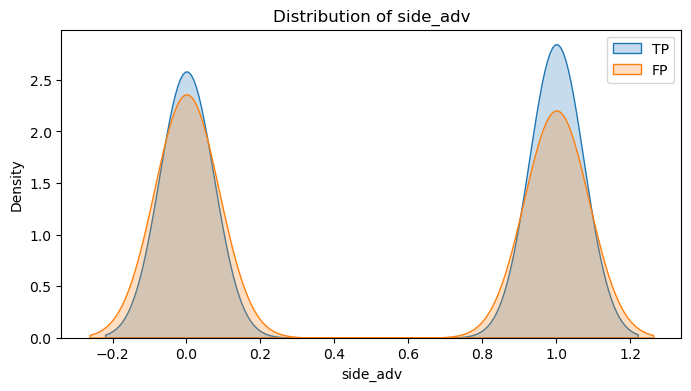

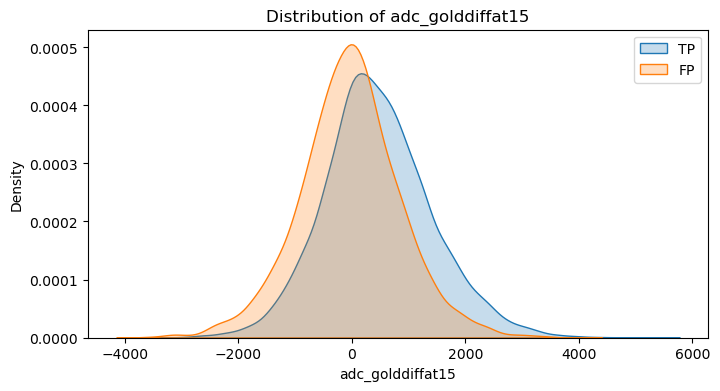

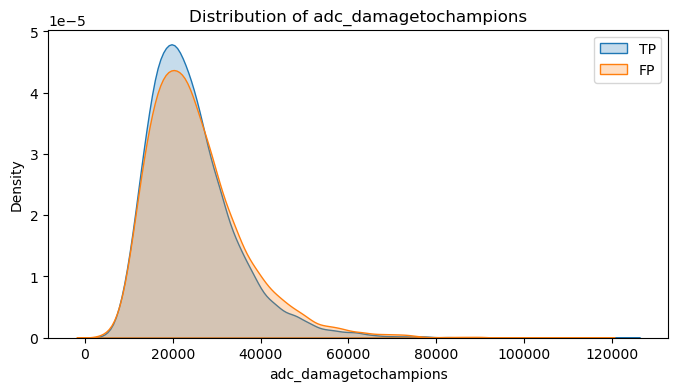

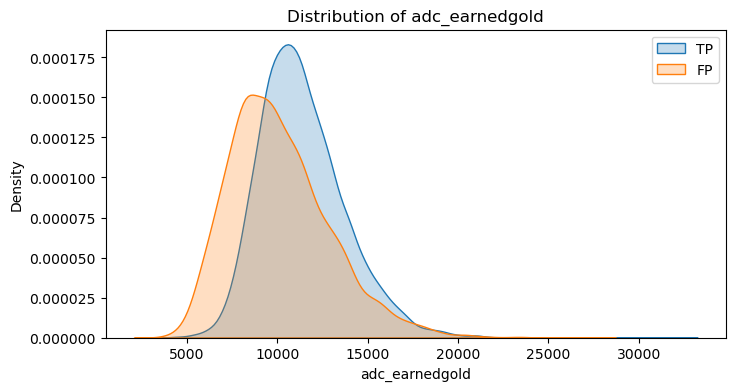

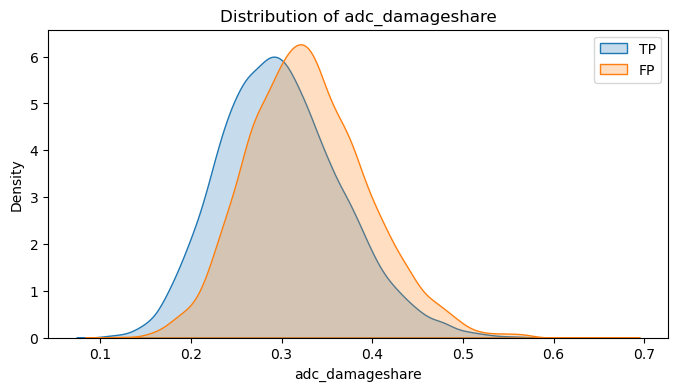

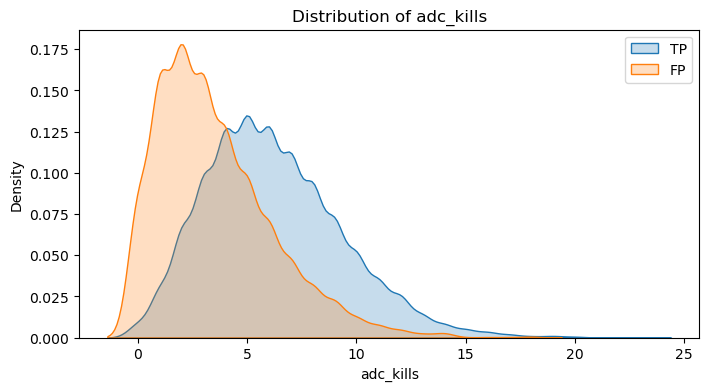

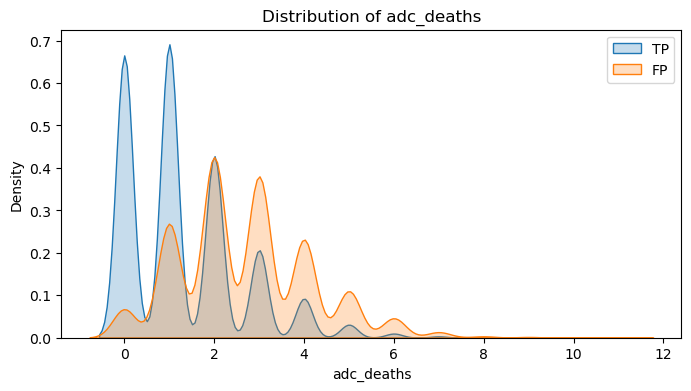

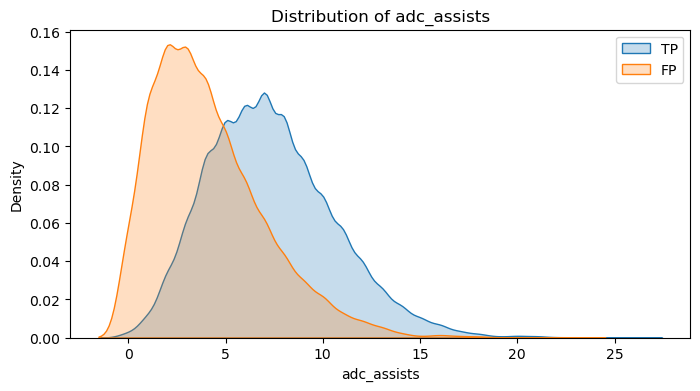

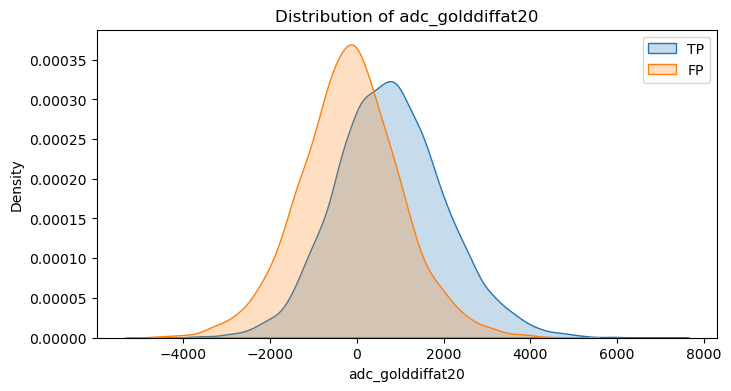

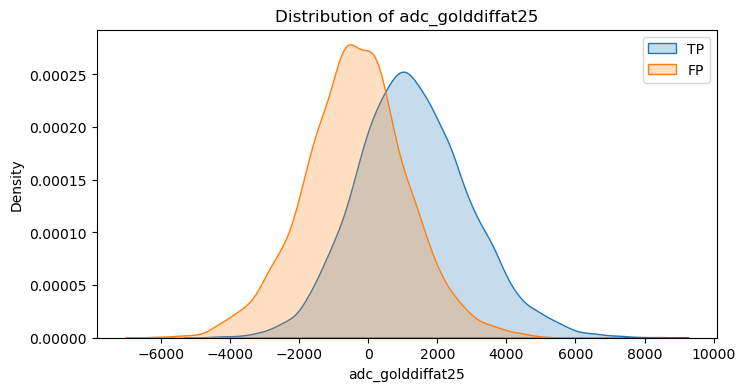

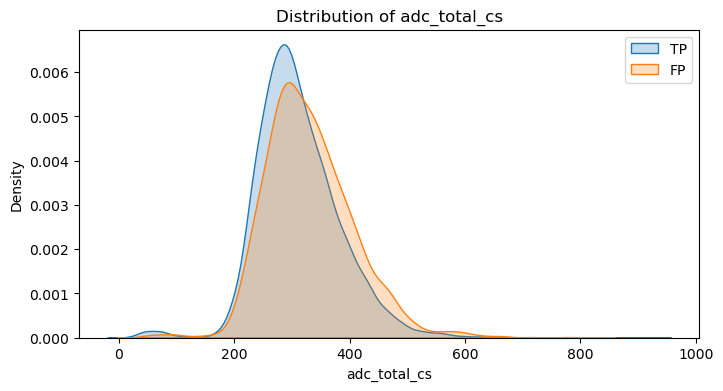

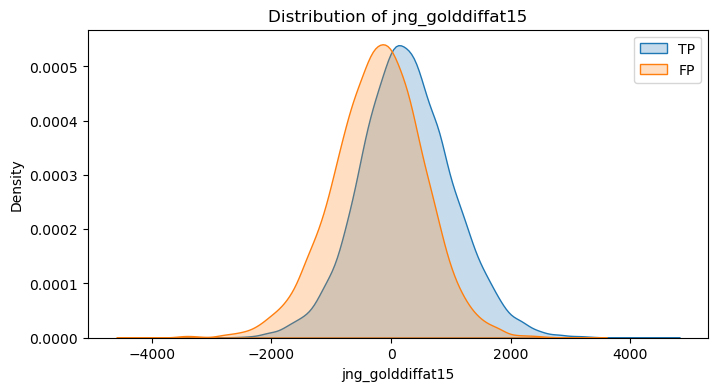

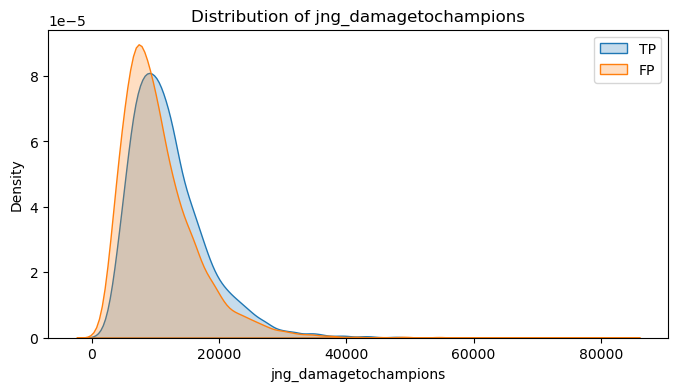

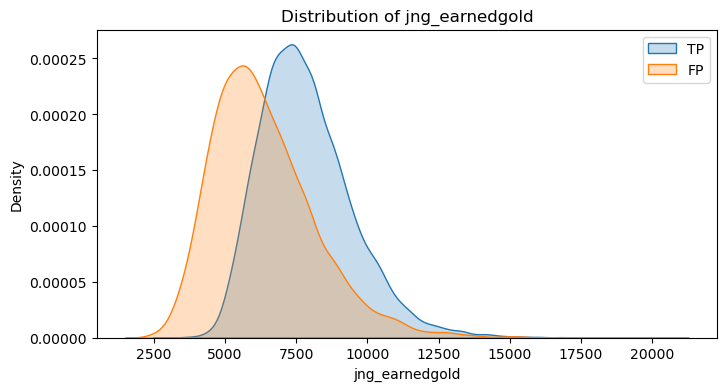

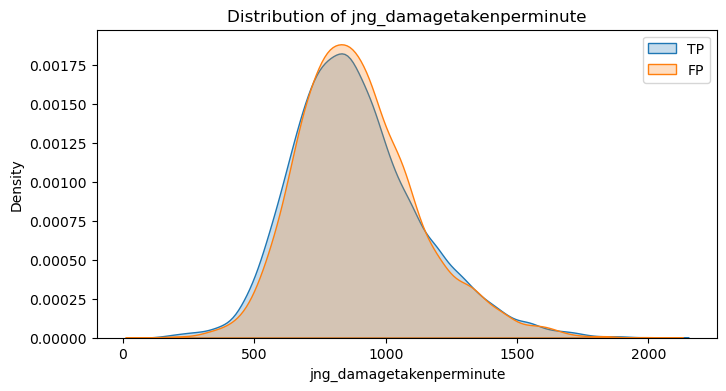

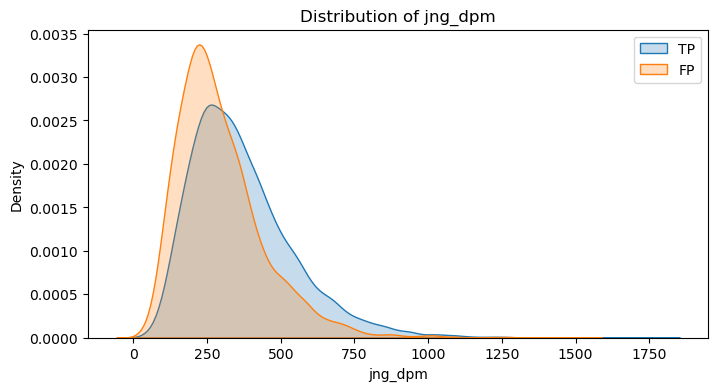

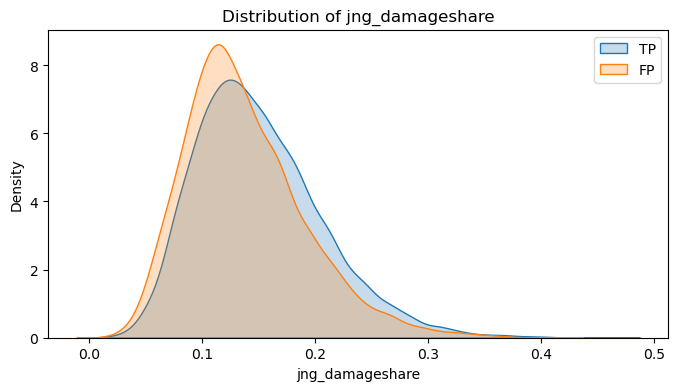

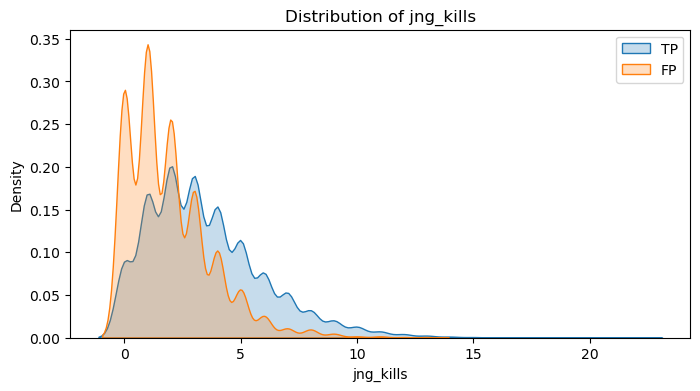

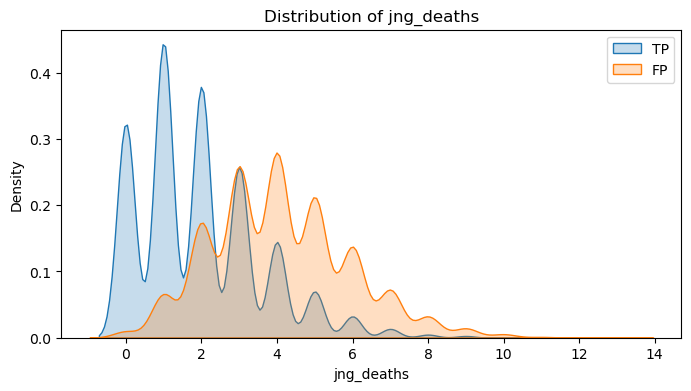

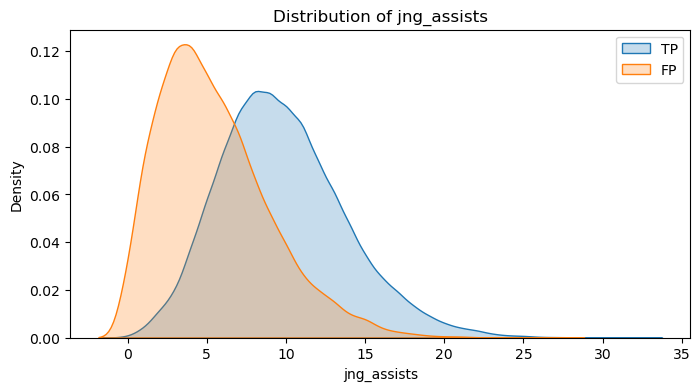

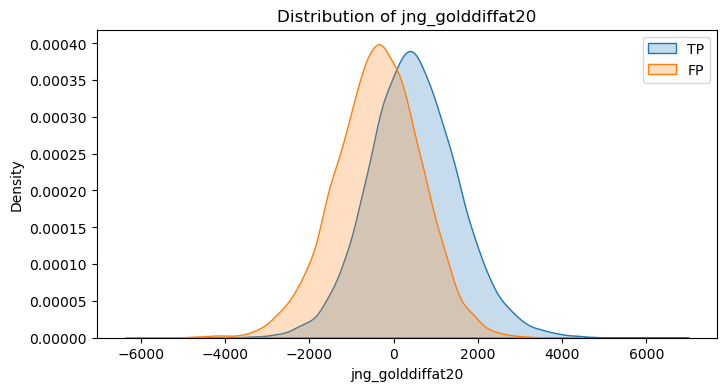

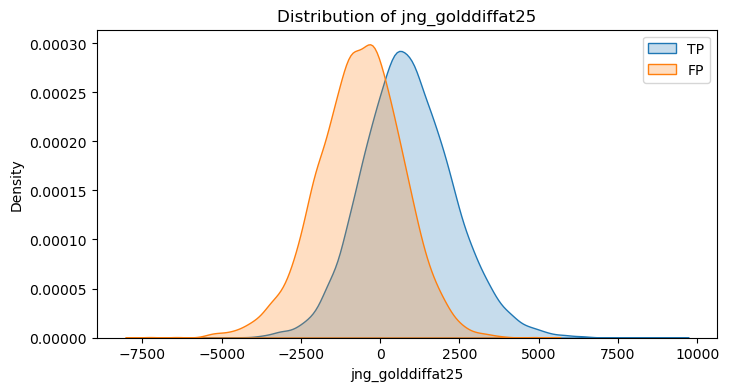

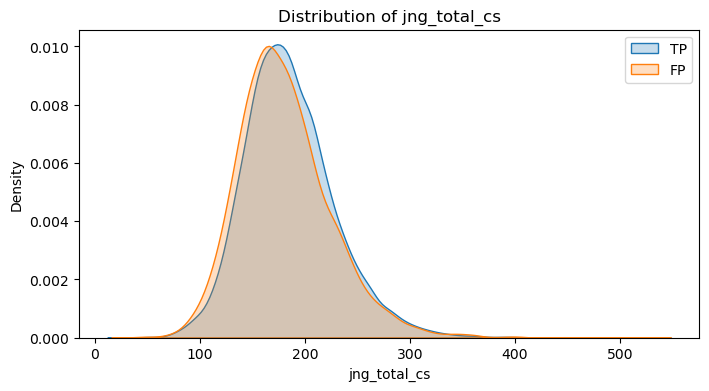

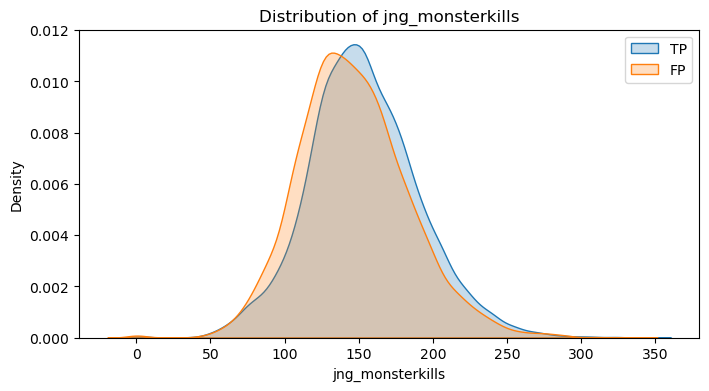

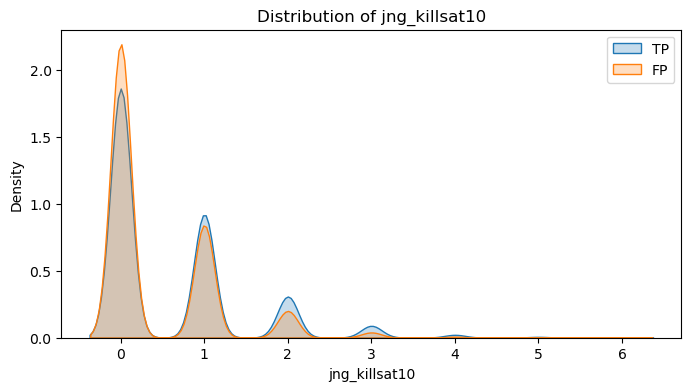

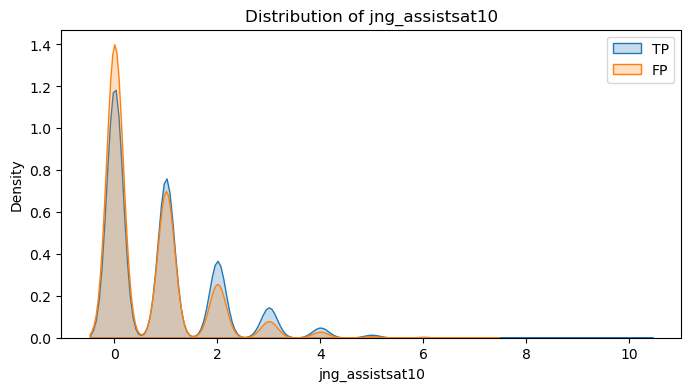

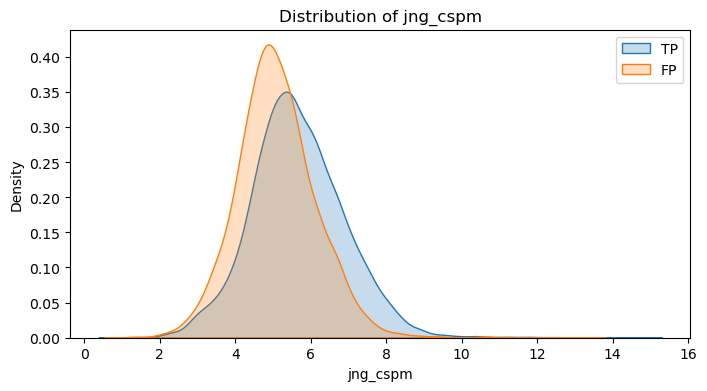

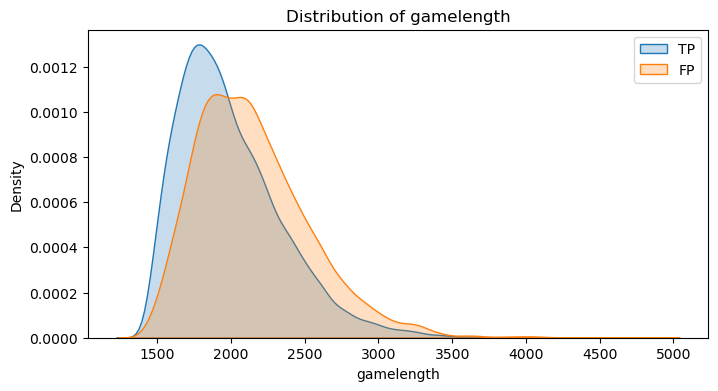

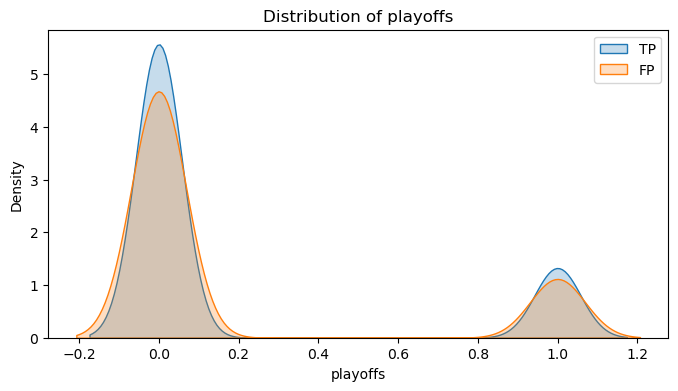

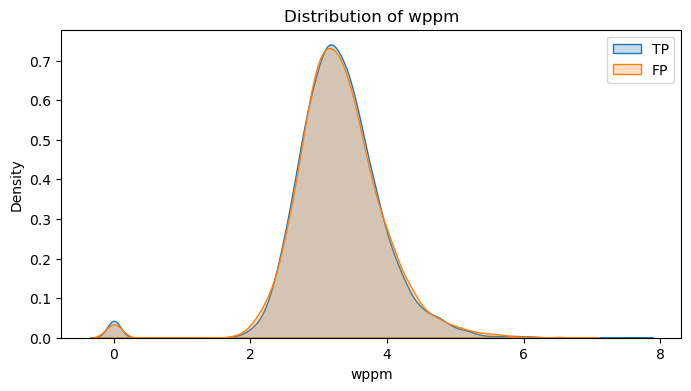

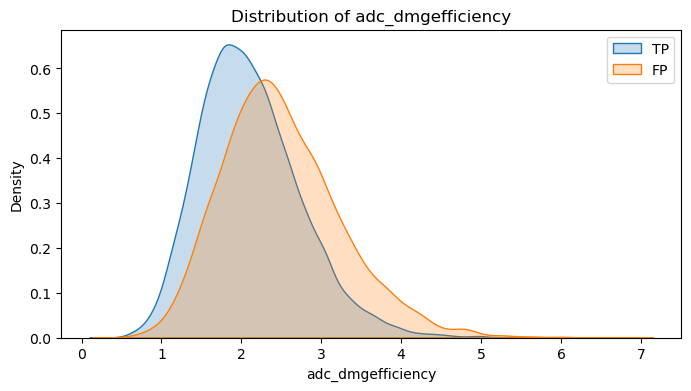

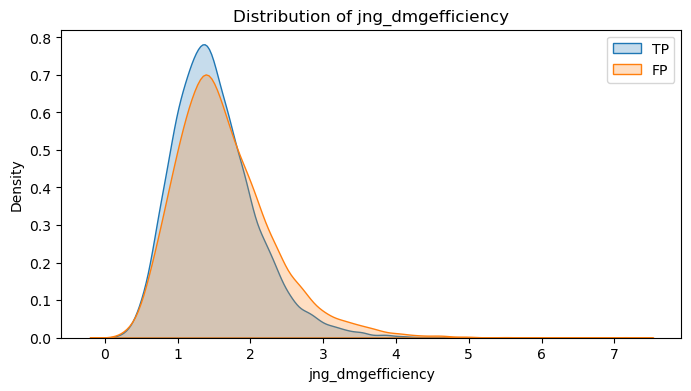

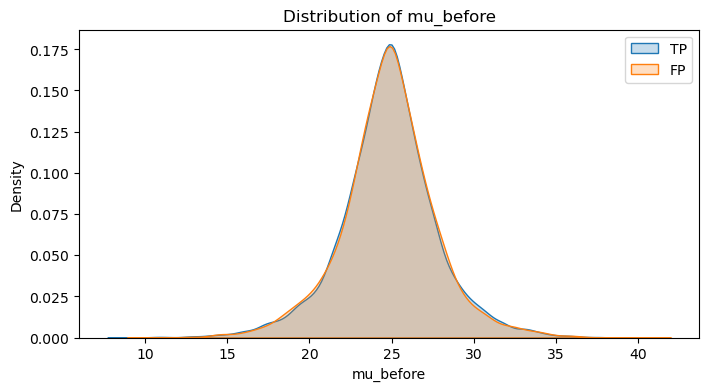

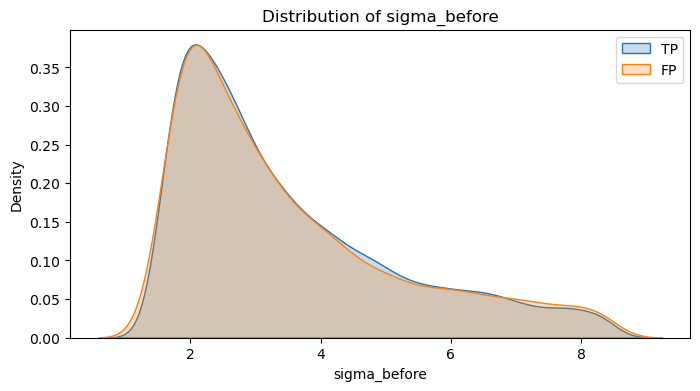

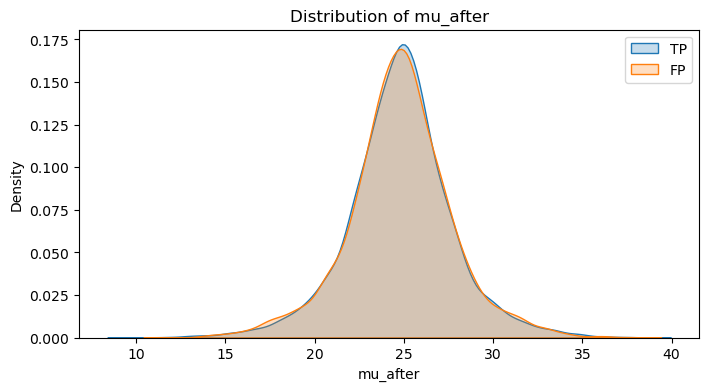

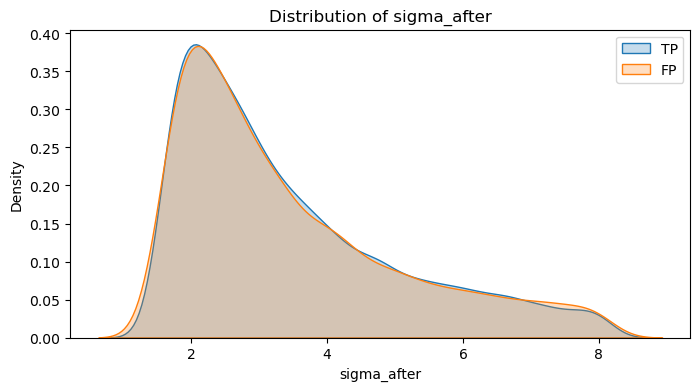

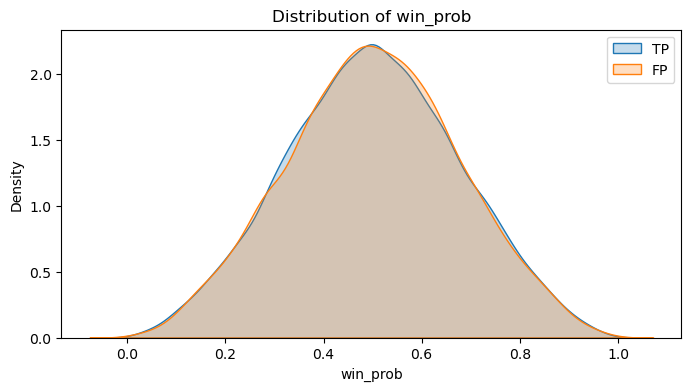

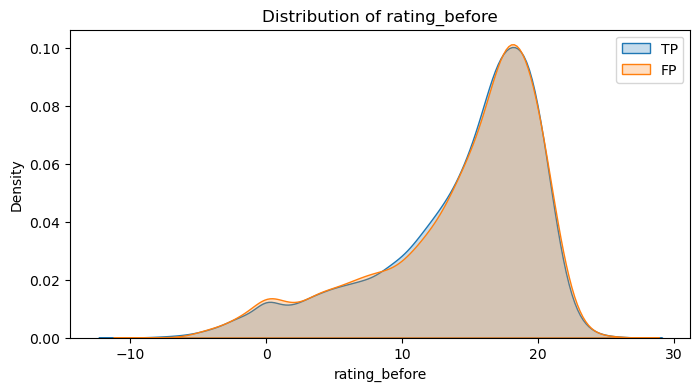

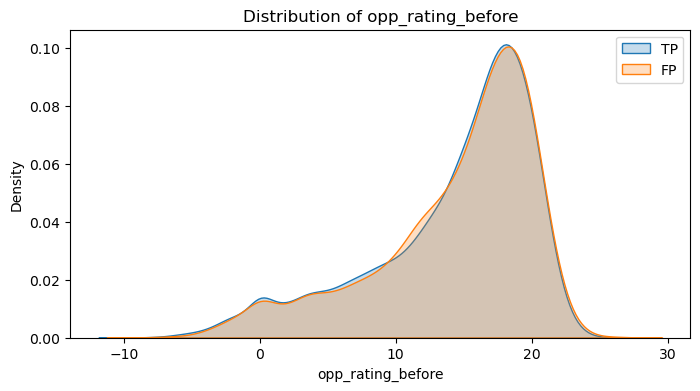

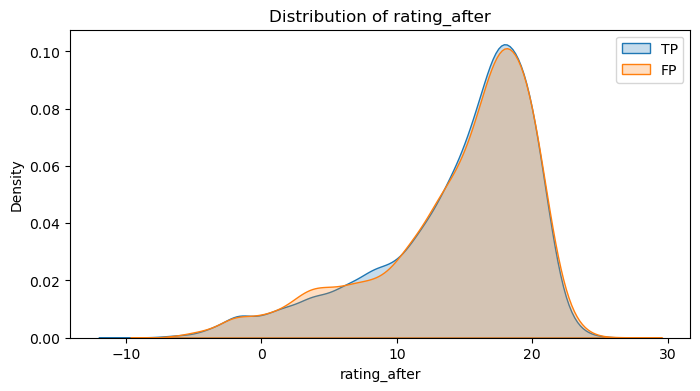

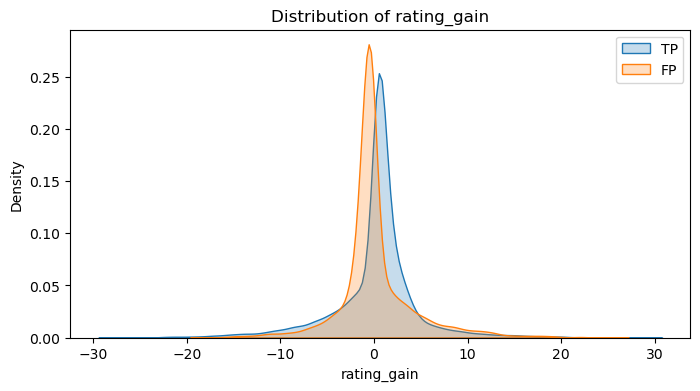

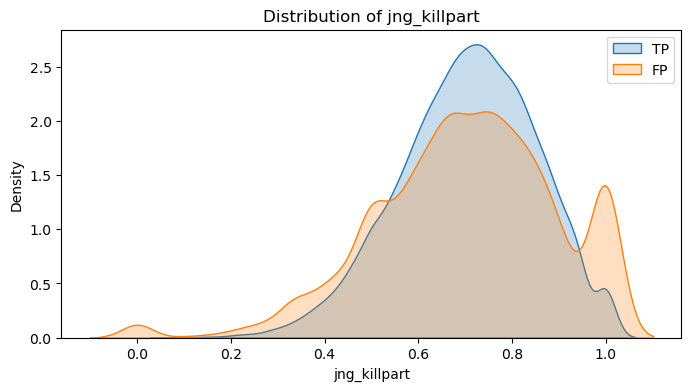

C:\Users\Johannes\AppData\Local\Temp\ipykernel_22124\4086456469.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(tp[feature], label="TP", fill=True)
C:\Users\Johannes\AppData\Local\Temp\ipykernel_22124\4086456469.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(fp[feature], label="FP", fill=True)
C:\Users\Johannes\AppData\Local\Temp\ipykernel_22124\4086456469.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


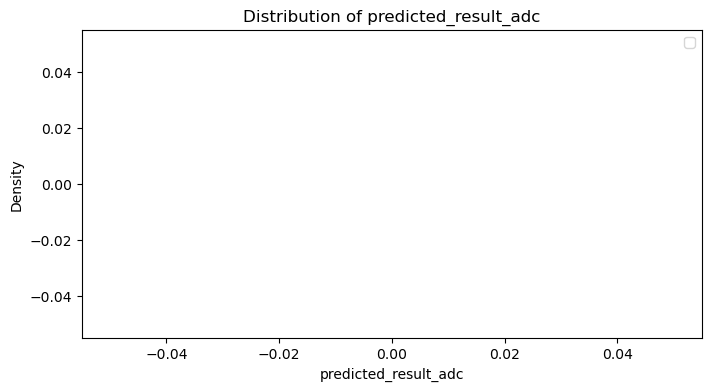

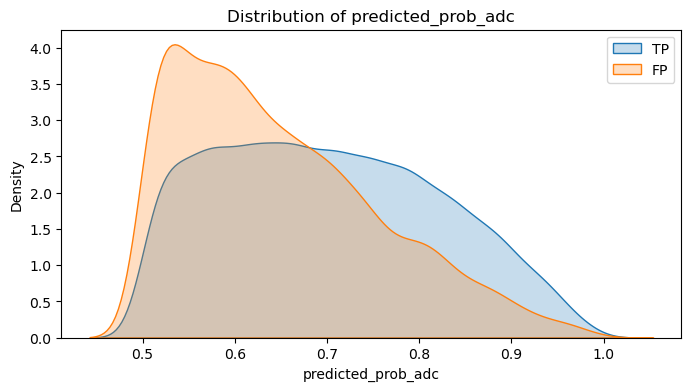

In [ ]:
#Model other features as distribution of tp vs fp

for feature in other_features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(tp[feature], label="TP", fill=True)
    sns.kdeplot(fp[feature], label="FP", fill=True)
    plt.title(f"Distribution of {feature}")
    plt.legend()
    plt.show()

    #from this the most noticable is definetely the adc_deaths as a strong indicator increasing accuracy by around 9% 
    #have closer look at FN and TN again
    #also look at the papers 

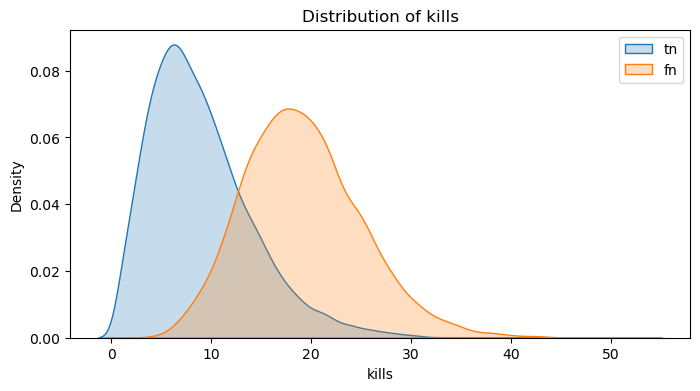

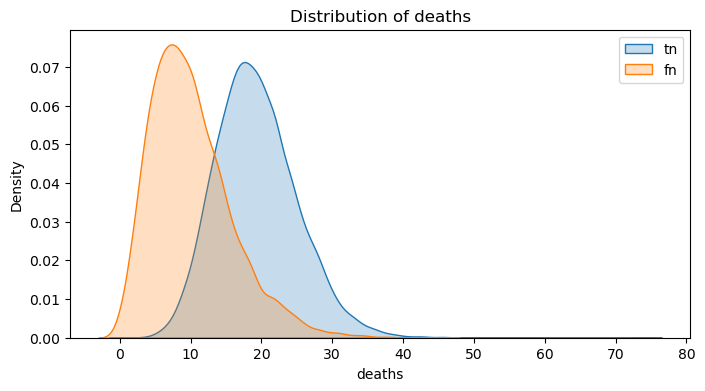

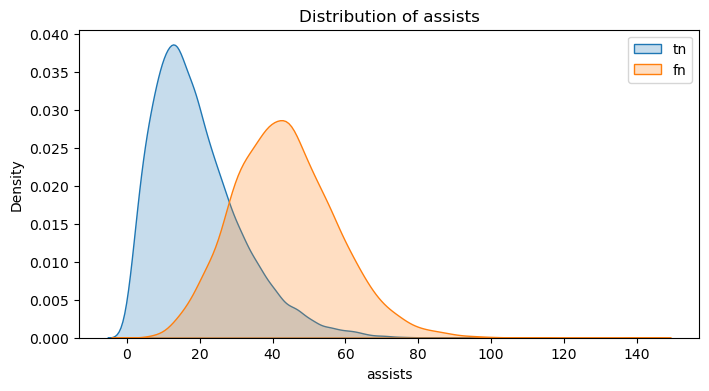

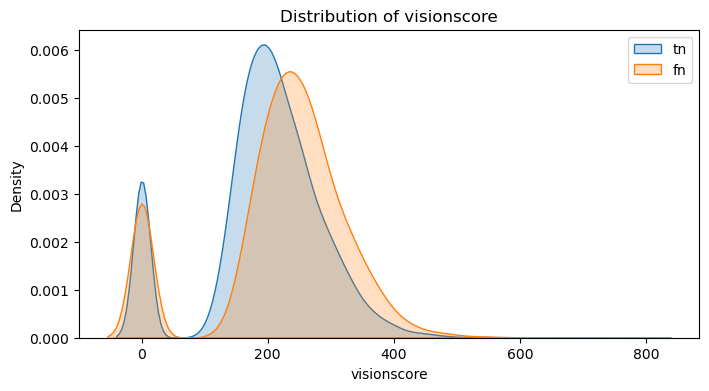

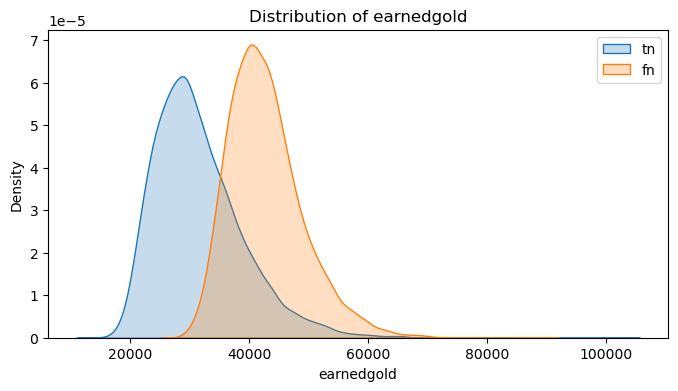

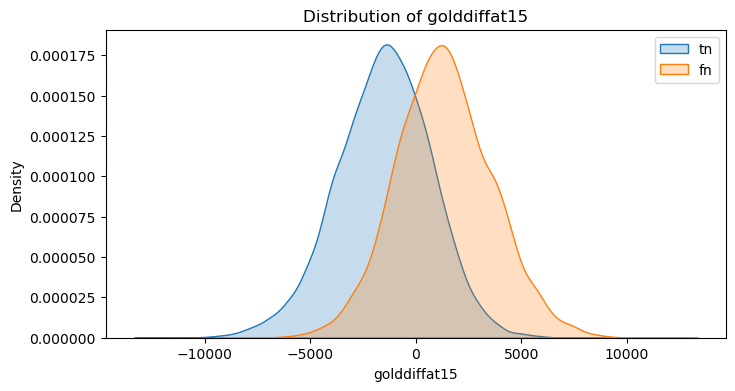

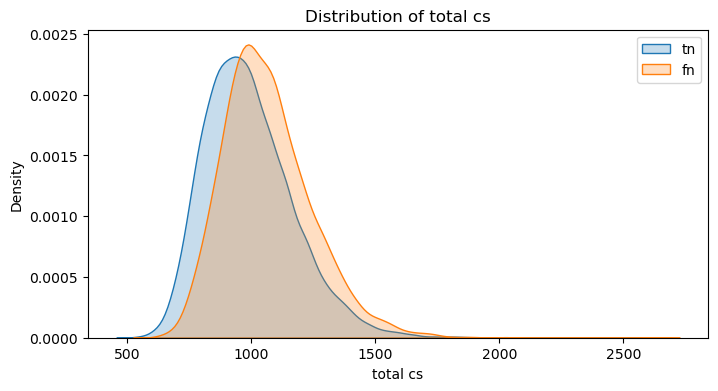

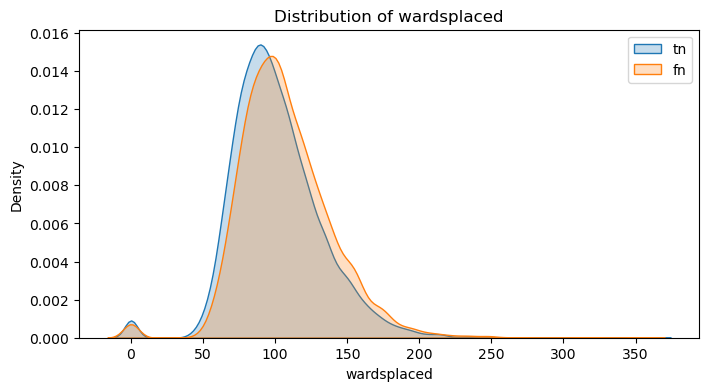

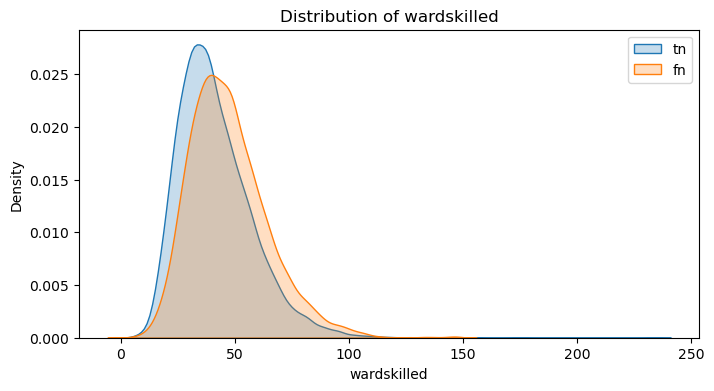

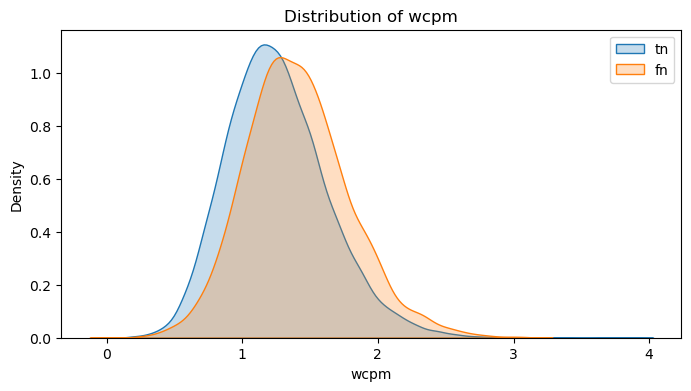

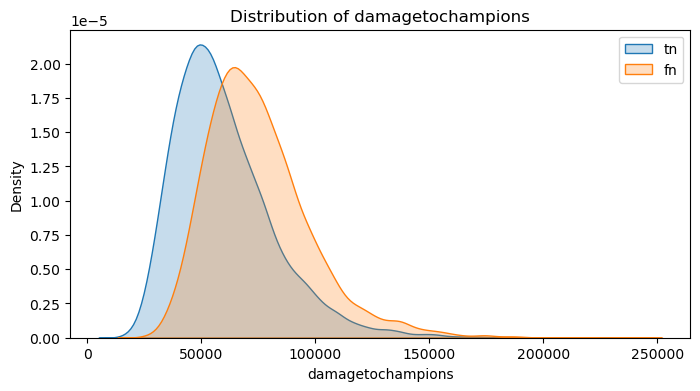

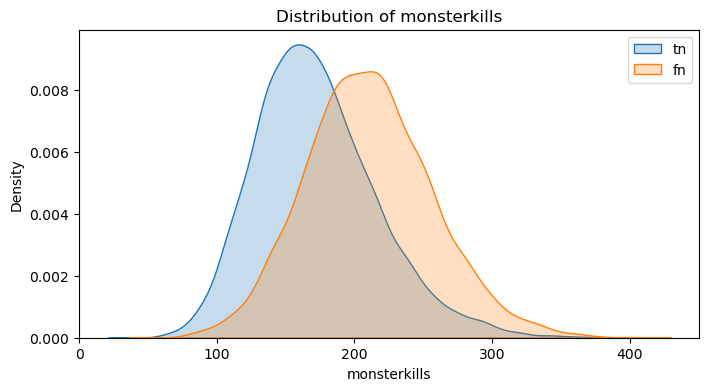

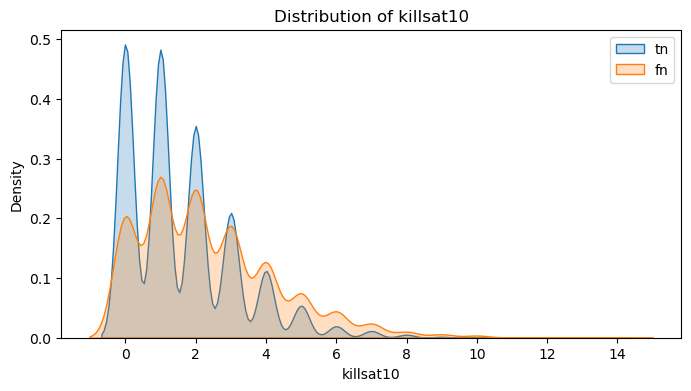

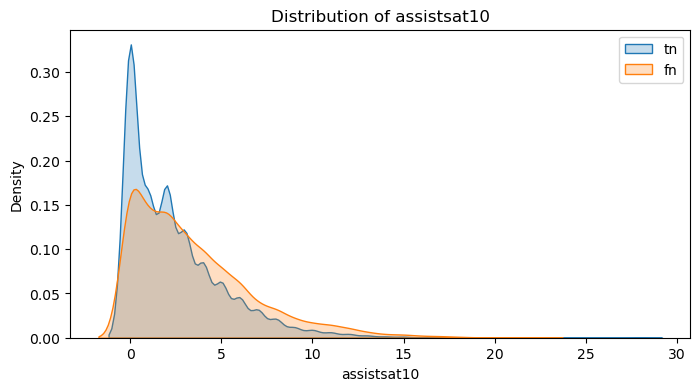

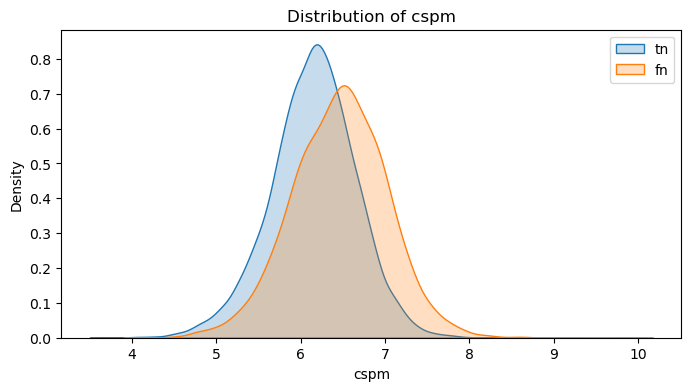

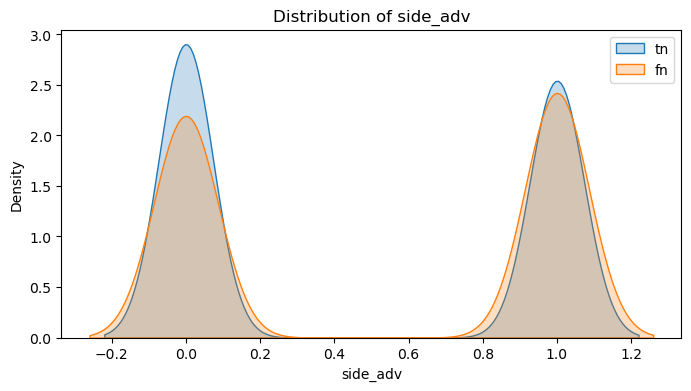

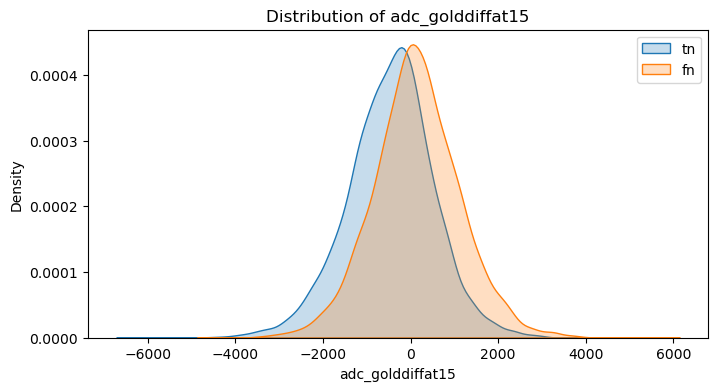

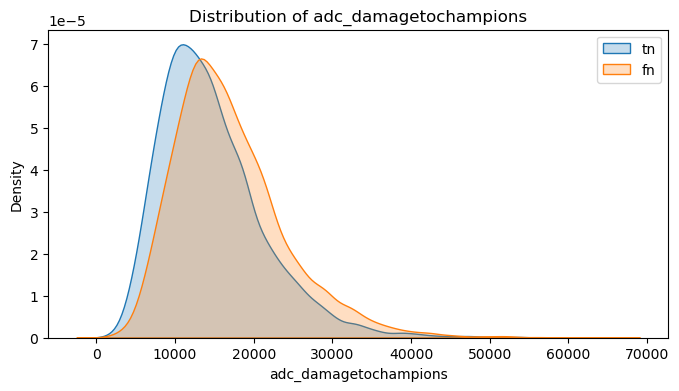

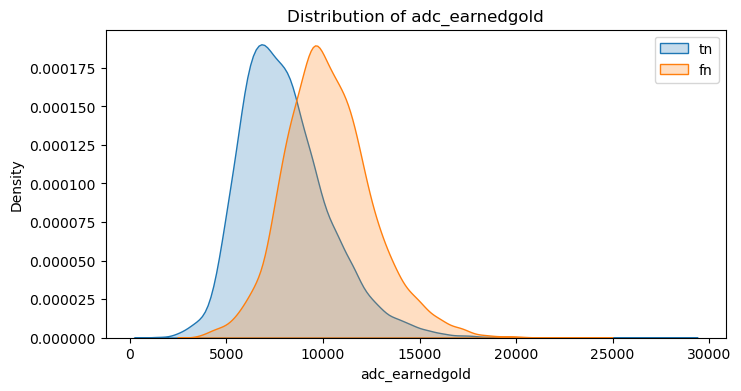

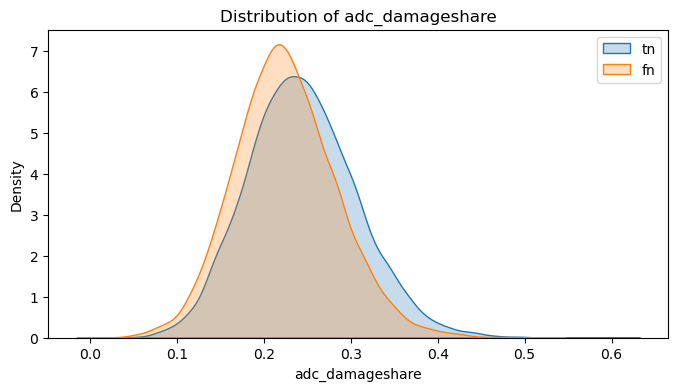

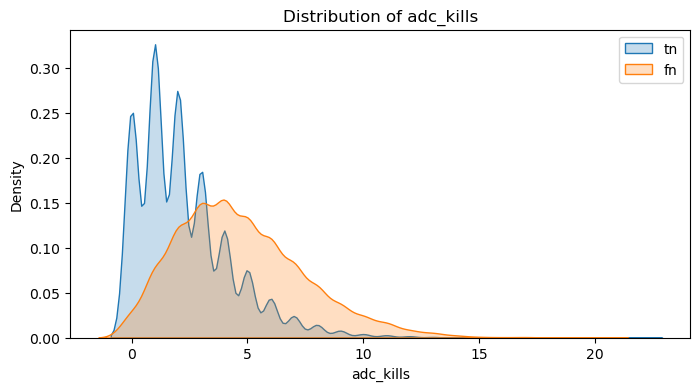

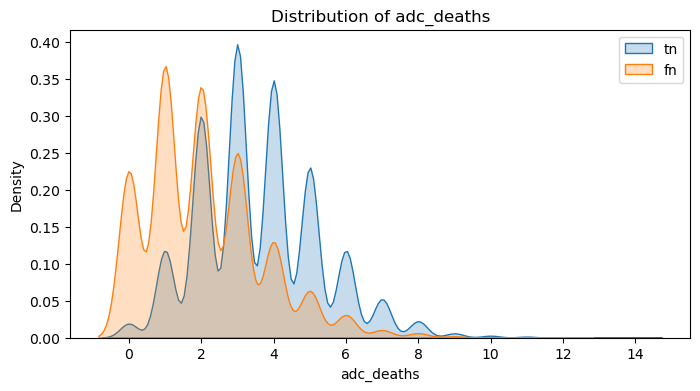

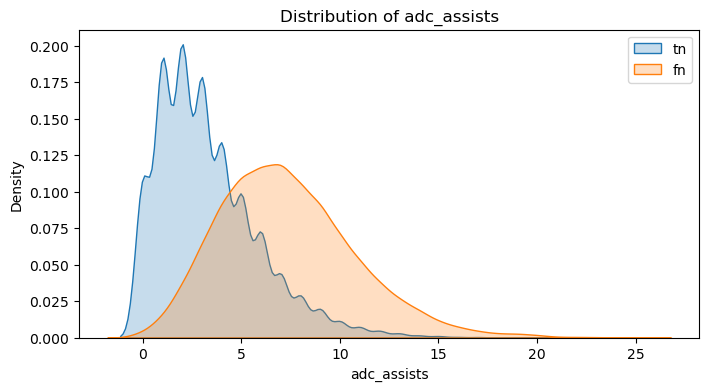

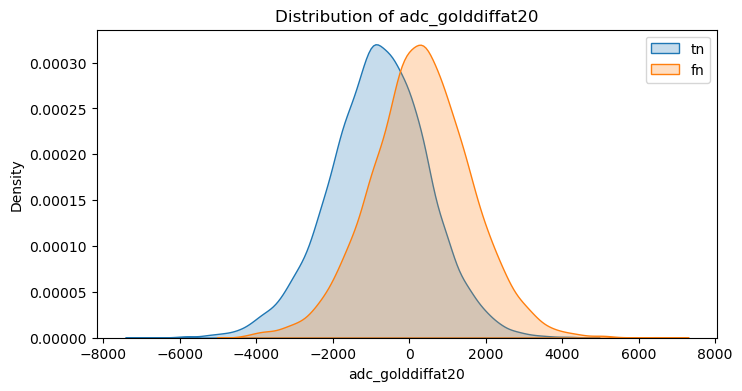

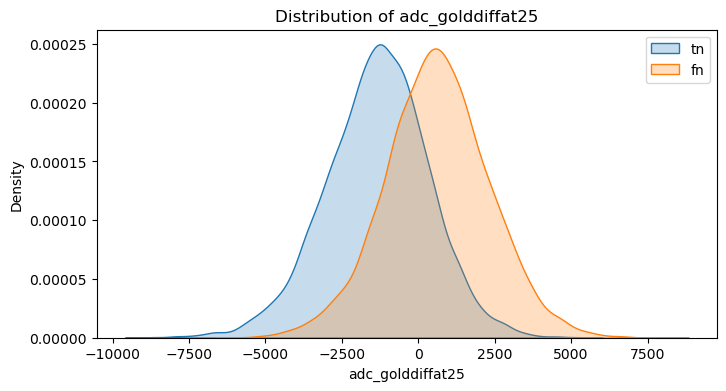

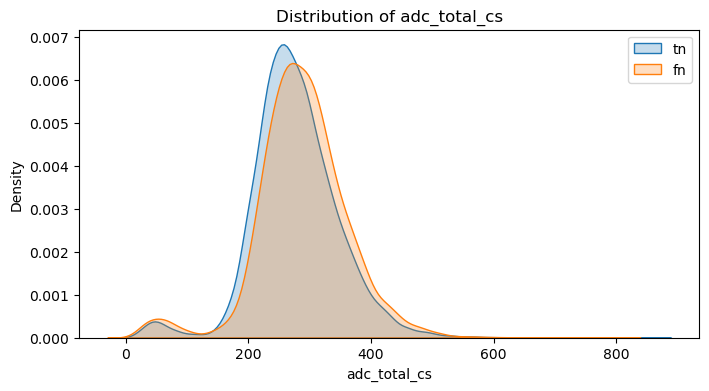

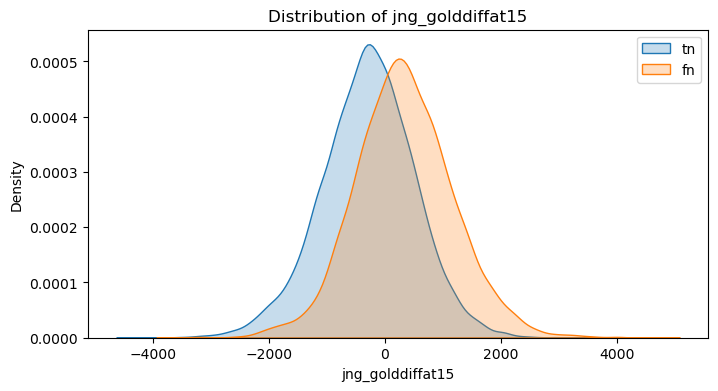

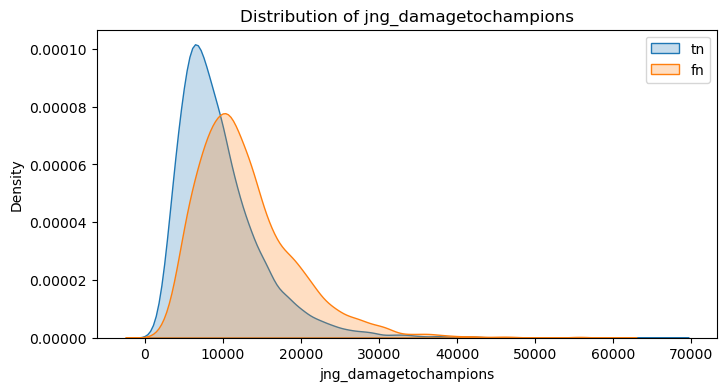

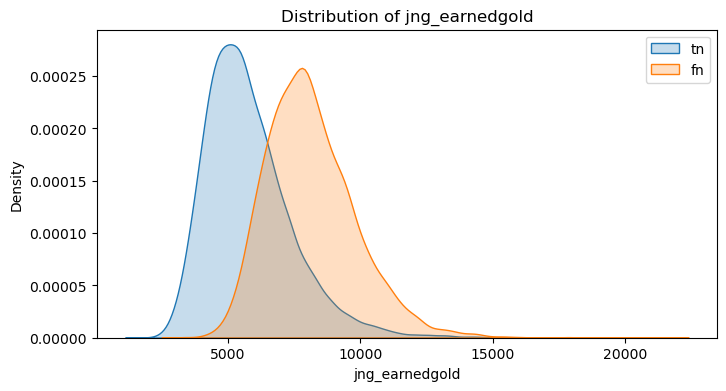

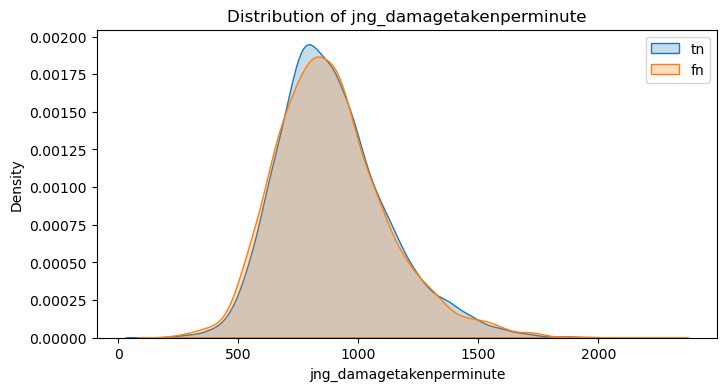

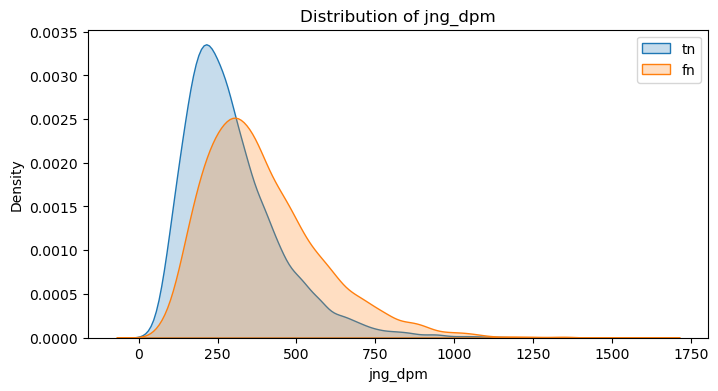

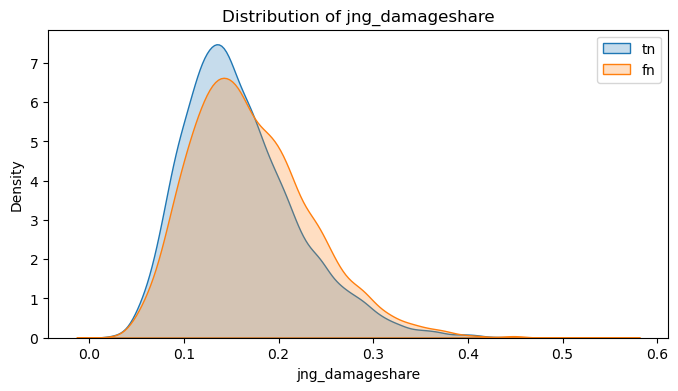

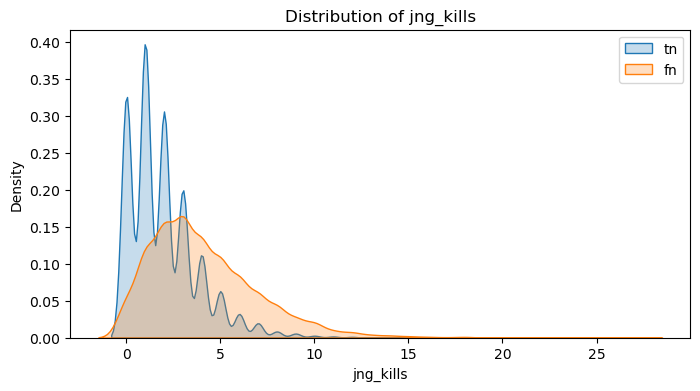

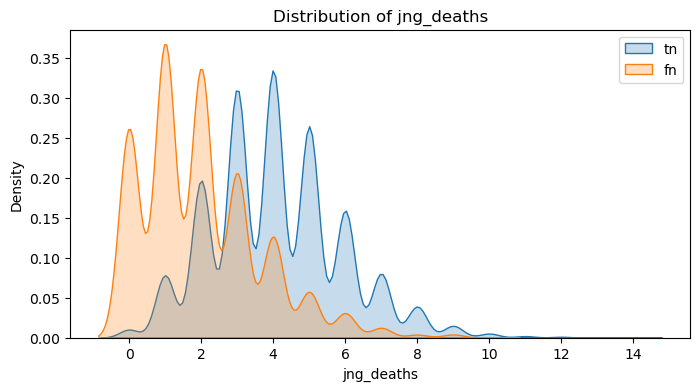

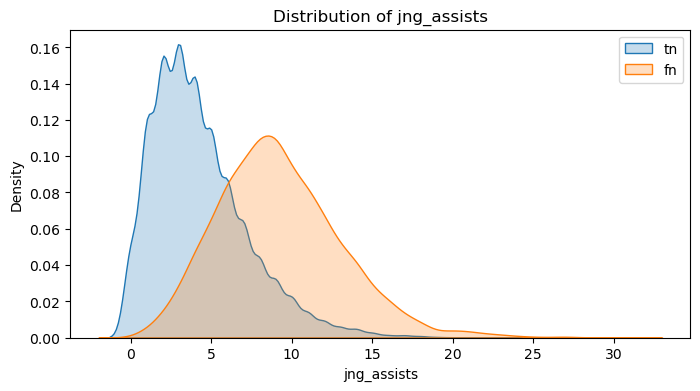

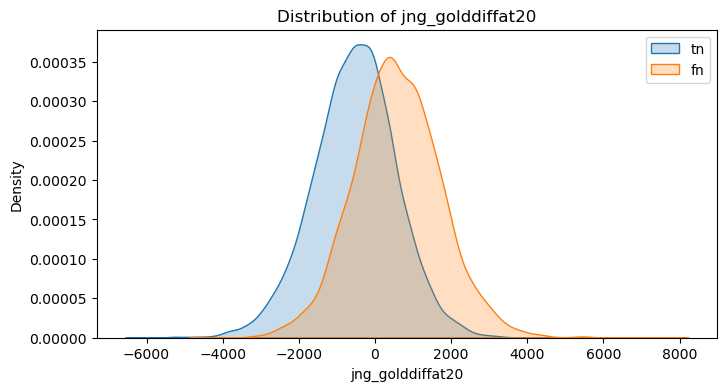

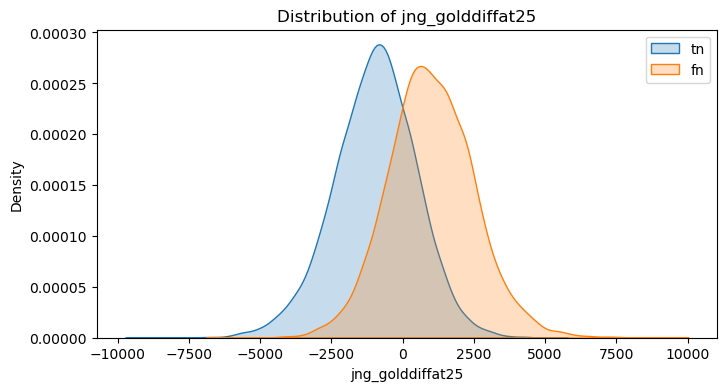

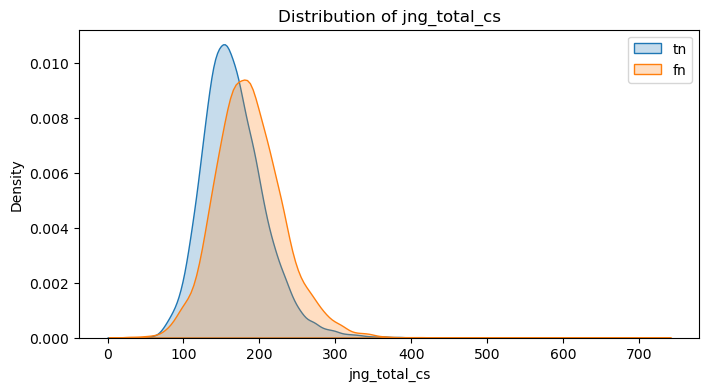

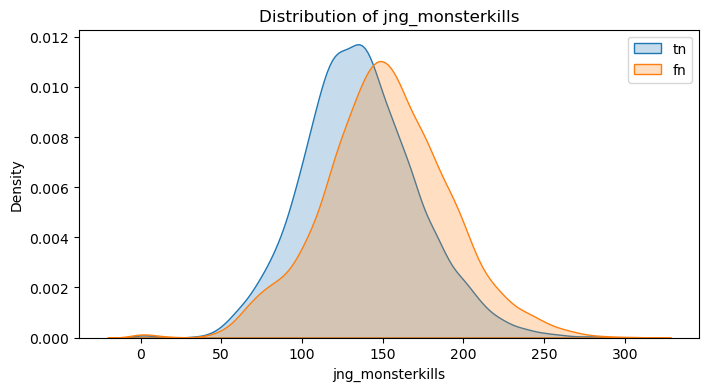

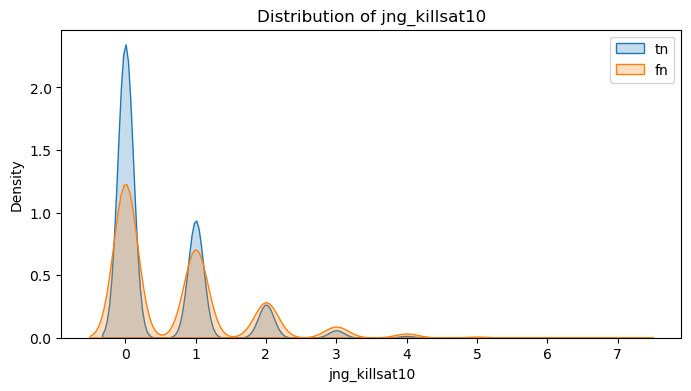

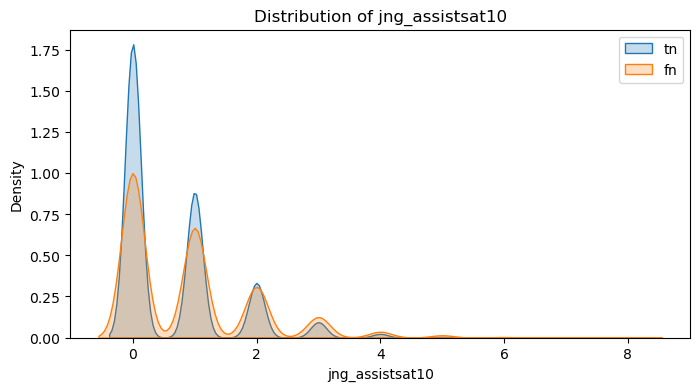

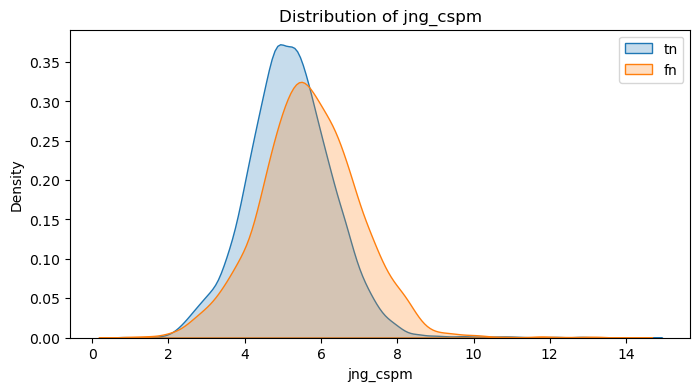

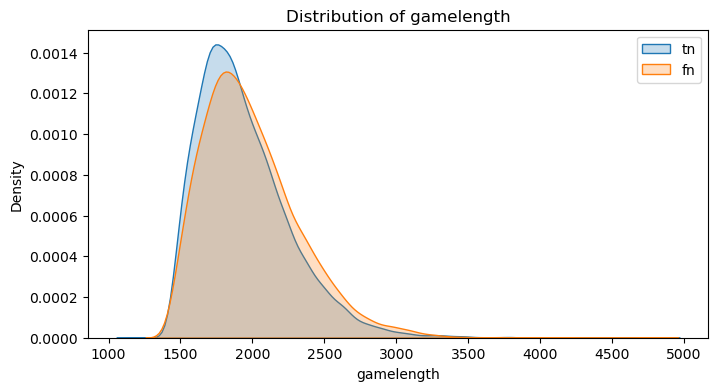

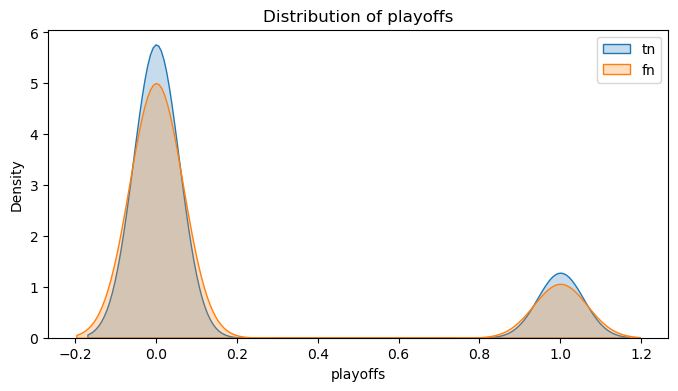

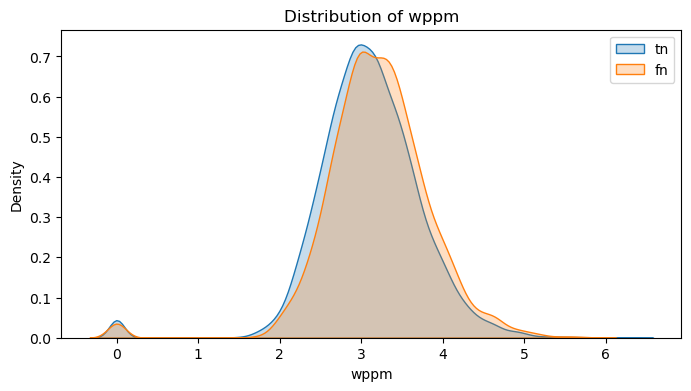

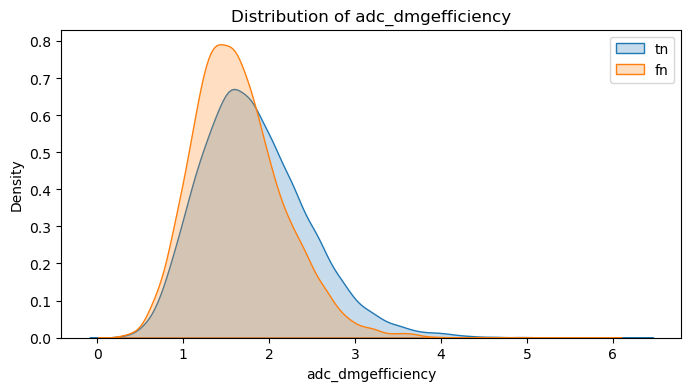

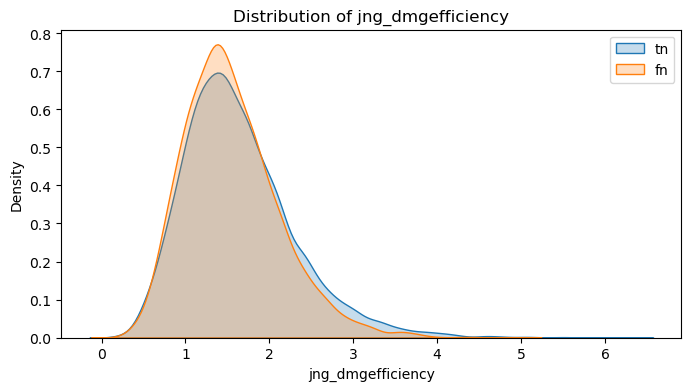

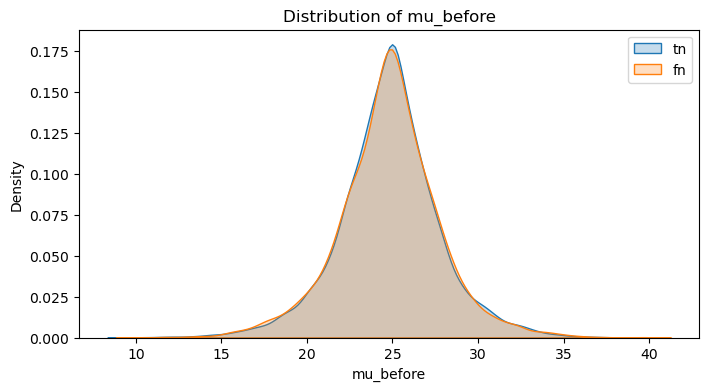

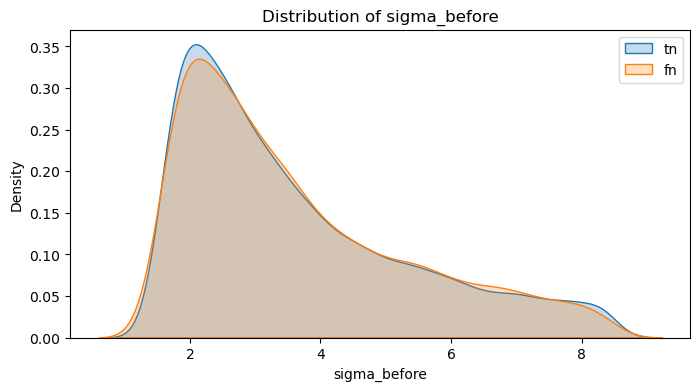

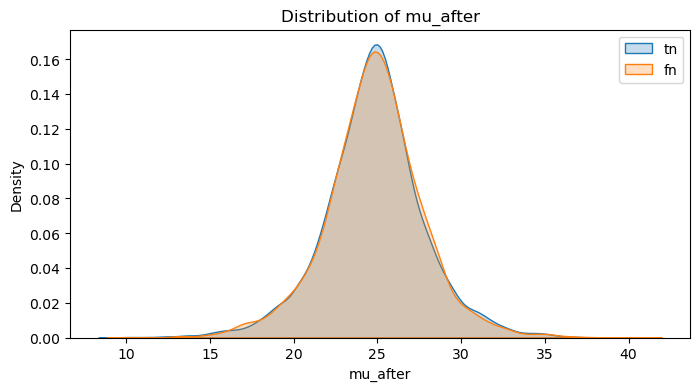

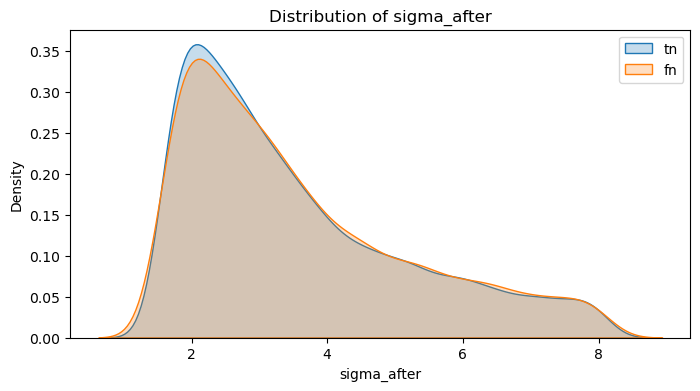

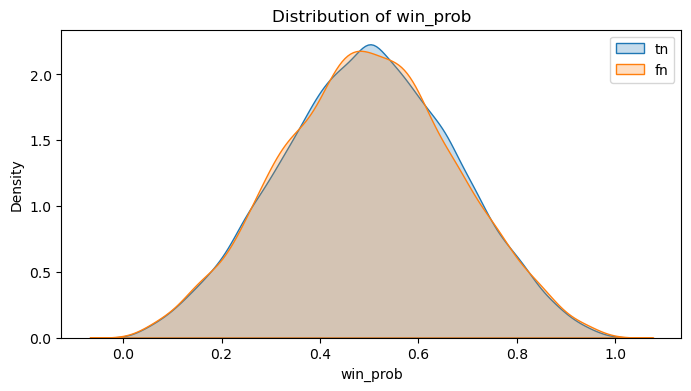

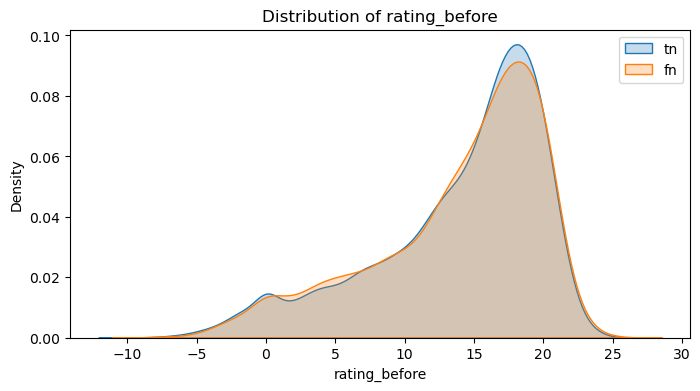

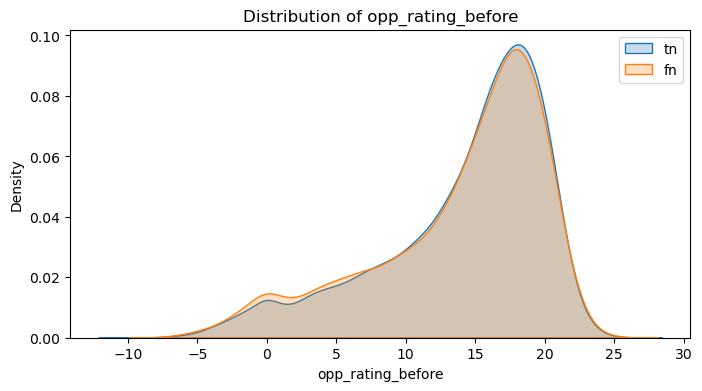

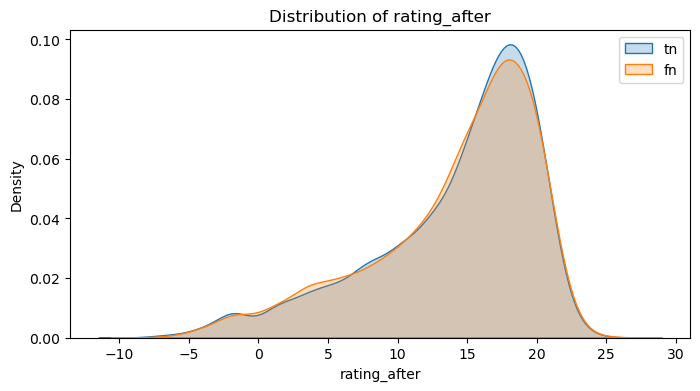

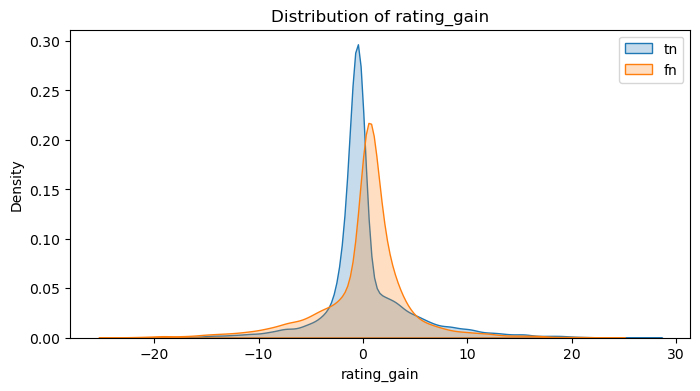

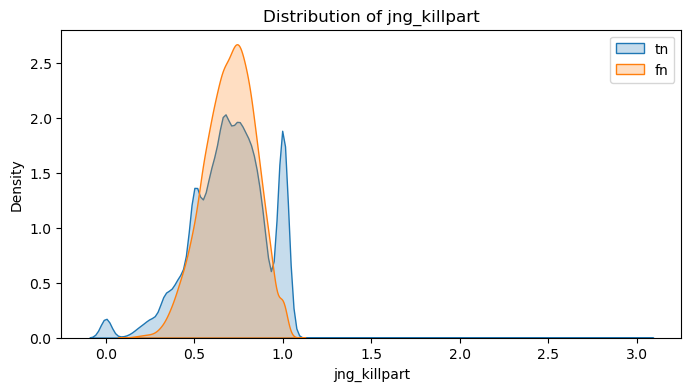

C:\Users\Johannes\AppData\Local\Temp\ipykernel_22124\2015413036.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(tn[feature], label="tn", fill=True)
C:\Users\Johannes\AppData\Local\Temp\ipykernel_22124\2015413036.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(fn[feature], label="fn", fill=True)
C:\Users\Johannes\AppData\Local\Temp\ipykernel_22124\2015413036.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


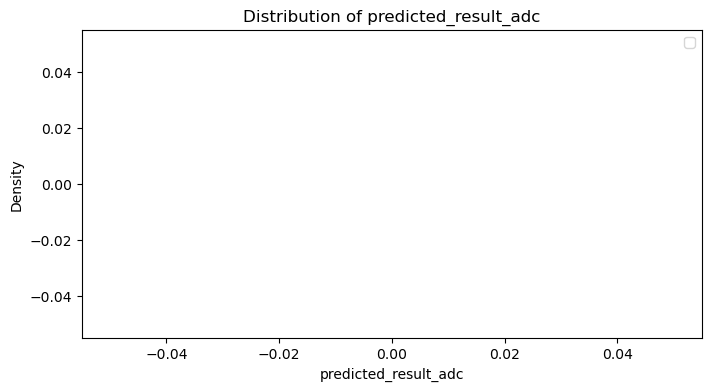

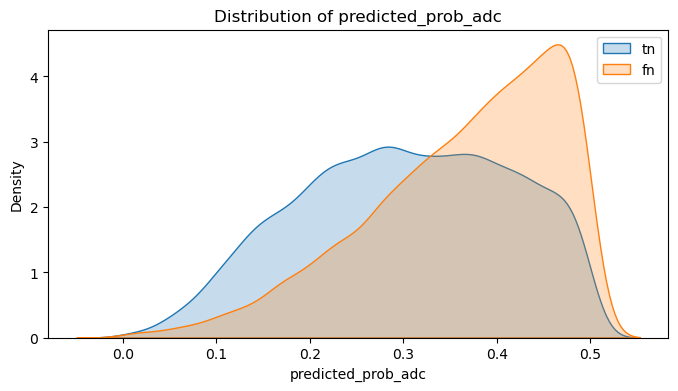

In [36]:
#Now look at the same comparison but between FN and TN
for feature in other_features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(tn[feature], label="tn", fill=True)
    sns.kdeplot(fn[feature], label="fn", fill=True)
    plt.title(f"Distribution of {feature}")
    plt.legend()
    plt.show()

In [ ]:
#Look at what are the major differences by looking at the distributions of correct win pred and wrong win pred 

In [15]:
model_base = smf.logit(
    'result ~ Q("total cs")',
    data=df
).fit()

print(model_base.summary())


Optimization terminated successfully.
         Current function value: 0.684605
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:               139197
Model:                          Logit   Df Residuals:                   139195
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                 0.01232
Time:                        14:22:45   Log-Likelihood:                -95295.
converged:                       True   LL-Null:                       -96483.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.4247      0.030    -46.923      0.000      -1.484      -1.365
Q("total cs")     0.

In [21]:
model = smf.logit(
    "result ~ adc_golddiffat15 + jng_golddiffat15",
    data=df
).fit()

print(model.summary())
#kind of implies that cs is stronger performance indicator for jungle than for adc 
#adc_total_cs    1.000581
#jng_total_cs    1.007934
#adc_kills    1.497634
#jng_kills    1.358577
import numpy as np

np.exp(model.params)

Optimization terminated successfully.
         Current function value: 0.592880
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:               139197
Model:                          Logit   Df Residuals:                   139194
Method:                           MLE   Df Model:                            2
Date:                Sun, 11 Jan 2026   Pseudo R-squ.:                  0.1446
Time:                        14:31:27   Log-Likelihood:                -82527.
converged:                       True   LL-Null:                       -96483.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0054      0.006      0.905      0.365      -0.006       0.017
adc_golddif

Intercept           1.005386
adc_golddiffat15    1.000670
jng_golddiffat15    1.000809
dtype: float64